# Price optimisation based on price elasticity of demand

Price elasticity of demand is the degree to which effective desire for some commodities changes as their price changes. As price gets expensive the desire to purchose those commodities decreases. For some commodities, desire may drop drastically with a little price increase while for other commodities, it may stay more or less the same even with a significant price increase. The term elasticity is used to refer this sensitivity to price increases. In generl, price elasticity is defined as the percentage change in quantity demanded when there is a one percent increase in price, holding the remaining factors constant.

This price optimization code uses sales of items for a cafe in China, which sells burgers, coke, lemonade and coffee.

In [1]:
# importing reqiured libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols # ols refers ordinary list square method in the statsmodels model
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [2]:
# display multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

### loading the data

In [4]:
sold_df = pd.read_csv('Cafe_Sell_Meta_Data.csv')
transactions_df = pd.read_csv('Cafe_Transaction_Store.csv')
dateInfo_df = pd.read_csv('Cafe_DateInfo.csv')

In [5]:
# checking head of the sell meta data
sold_df.head()

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME
0,1070,0,7821,BURGER
1,3055,0,3052,COFFEE
2,3067,0,5030,COKE
3,3028,0,6249,LEMONADE
4,2051,2,7821,BURGER


In [6]:
sold_df.shape

(11, 4)

In [7]:
sold_df.describe()

,SELL_ID,SELL_CATEGORY,ITEM_ID
count,11.000000,11.000000,11.000000
mean,2235.000000,1.272727,5906.909091
std,598.728653,1.009050,1830.217170
min,1070.000000,0.000000,3052.000000
25%,2051.500000,0.000000,5030.000000
50%,2053.000000,2.000000,6249.000000
75%,2540.500000,2.000000,7821.000000
max,3067.000000,2.000000,7821.000000


In [8]:
sold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SELL_ID        11 non-null     int64 
 1   SELL_CATEGORY  11 non-null     int64 
 2   ITEM_ID        11 non-null     int64 
 3   ITEM_NAME      11 non-null     object
dtypes: int64(3), object(1)
memory usage: 480.0+ bytes


In [9]:
sold_df.describe(include = ['object']) 

,ITEM_NAME
count,11
unique,4
top,BURGER
freq,4


In [10]:
sold_df["ITEM_NAME"].value_counts()

BURGER      4
COKE        3
COFFEE      2
LEMONADE    2
Name: ITEM_NAME, dtype: int64

In [11]:
# checking missing values with the sold dataframe
sold_df.isnull().sum()

SELL_ID          0
SELL_CATEGORY    0
ITEM_ID          0
ITEM_NAME        0
dtype: int64

There are no missing values in the sell meta data.

In [12]:
transactions_df.head()

,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
0,01/01/12,15.50,46,1070,0
1,01/01/12,12.73,22,2051,2
2,01/01/12,12.75,18,2052,2
3,01/01/12,12.60,30,2053,2
4,01/02/12,15.50,70,1070,0


In [13]:
transactions_df.shape

(5404, 5)

In [14]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CALENDAR_DATE  5404 non-null   object 
 1   PRICE          5404 non-null   float64
 2   QUANTITY       5404 non-null   int64  
 3   SELL_ID        5404 non-null   int64  
 4   SELL_CATEGORY  5404 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 211.2+ KB


In [15]:
transactions_df.describe()

,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
count,5404.000000,5404.000000,5404.00000,5404.000000
mean,12.868729,44.335307,1806.50000,1.500000
std,1.563922,25.502597,425.25841,0.866106
min,10.120000,8.000000,1070.00000,0.000000
25%,11.530000,24.000000,1805.75000,1.500000
50%,12.640000,36.000000,2051.50000,2.000000
75%,13.557500,60.000000,2052.25000,2.000000
max,16.500000,124.000000,2053.00000,2.000000


In [16]:
transactions_df.describe(include = ['object'])

,CALENDAR_DATE
count,5404
unique,1348
top,03/01/13
freq,16


In [17]:
# checking values with the transactions dataframe
transactions_df.isnull().sum()

CALENDAR_DATE    0
PRICE            0
QUANTITY         0
SELL_ID          0
SELL_CATEGORY    0
dtype: int64

There are no missing values in the transaction data.

### exploring the data

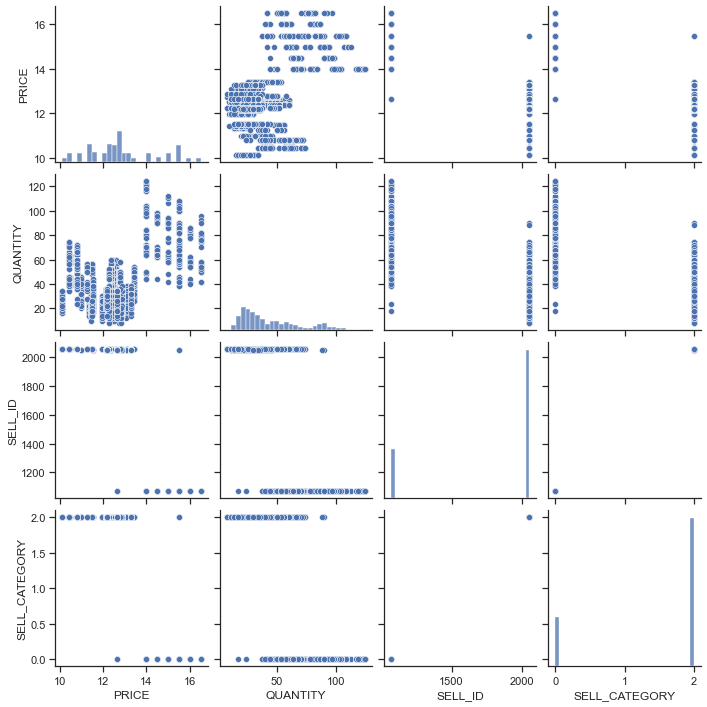

In [18]:
sns.pairplot(transactions_df)

The price and quantity distributions show two or more groups/distributions of data, which suggest that these groups/distributions of data may need to be modeled separatly to provide robust predictions.

(array([ 360.,  509.,  629., 1351., 1082.,  122.,  389.,  240.,  482.,
         240.]),
 array([10.12 , 10.758, 11.396, 12.034, 12.672, 13.31 , 13.948, 14.586,
        15.224, 15.862, 16.5  ]),
 <BarContainer object of 10 artists>)

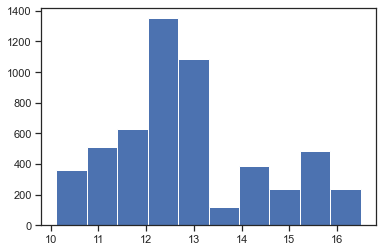

In [19]:
plt.hist(transactions_df.PRICE)

The price seems to have two or three distributions with peaks around 12, 14 and 15.

In [20]:
# checking the head of the dateinfo data
dateInfo_df.head()

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1/1/12,2012,New Year,1,0,24.8,0
1,1/2/12,2012,New Year,0,0,24.8,0
2,1/3/12,2012,New Year,0,0,32.0,1
3,1/4/12,2012,NaN,0,0,32.0,1
4,1/5/12,2012,NaN,0,0,24.8,0


In [21]:
dateInfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CALENDAR_DATE        1349 non-null   object 
 1   YEAR                 1349 non-null   int64  
 2   HOLIDAY              105 non-null    object 
 3   IS_WEEKEND           1349 non-null   int64  
 4   IS_SCHOOLBREAK       1349 non-null   int64  
 5   AVERAGE_TEMPERATURE  1349 non-null   float64
 6   IS_OUTDOOR           1349 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 73.9+ KB


In [22]:
dateInfo_df.describe()

,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,1349.000000,1349.000000,1349.000000,1349.000000,1349.000000
mean,2013.375093,0.285397,0.204596,56.326019,0.862120
std,1.073073,0.451771,0.403556,20.227597,0.344902
min,2012.000000,0.000000,0.000000,14.000000,0.000000
25%,2012.000000,0.000000,0.000000,35.600000,1.000000
50%,2013.000000,0.000000,0.000000,60.800000,1.000000
75%,2014.000000,1.000000,0.000000,75.200000,1.000000
max,2015.000000,1.000000,1.000000,87.800000,1.000000


In [23]:
dateInfo_df.describe(include = ['object'])

,CALENDAR_DATE,HOLIDAY
count,1349,105
unique,1348,8
top,3/1/13,Luner New Year
freq,2,28


In [24]:
dateInfo_df.shape

(1349, 7)

In [25]:
# checking missing values
dateInfo_df.isnull().sum()

CALENDAR_DATE             0
YEAR                      0
HOLIDAY                1244
IS_WEEKEND                0
IS_SCHOOLBREAK            0
AVERAGE_TEMPERATURE       0
IS_OUTDOOR                0
dtype: int64

Exploring further what this missing values entail.

In [26]:
dateInfo_df["HOLIDAY"].unique()

array(['New Year', nan, 'Luner New Year', 'Qing Ming Festival',
       'Labor Day', 'Dragon Boat Festivel', 'Mid-Autumn Day',
       'National Day', 'WWII Celebration'], dtype=object)

In [27]:
dateInfo_df["HOLIDAY"].value_counts()

Luner New Year          28
National Day            21
Dragon Boat Festivel    12
Qing Ming Festival      12
Labor Day               12
New Year                10
Mid-Autumn Day           7
WWII Celebration         3
Name: HOLIDAY, dtype: int64

In [28]:
dateInfo_df["HOLIDAY"].value_counts().sum()

105

Out of a shape of 1349 rows, only 105 values have none NaN values, which indicate that NaN values may be representing some form of data. Exploring the data further to indentify what they represent.

In [29]:
dateInfo_df[dateInfo_df.isnull().any(axis=1)]

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
3,1/4/12,2012,NaN,0,0,32.0,1
4,1/5/12,2012,NaN,0,0,24.8,0
5,1/6/12,2012,NaN,0,0,23.0,0
6,1/7/12,2012,NaN,1,0,26.6,0
7,1/8/12,2012,NaN,1,0,26.6,0
...,...,...,...,...,...,...,...
1344,9/6/15,2015,NaN,1,0,75.2,1
1345,9/7/15,2015,NaN,0,0,77.0,1
1346,9/8/15,2015,NaN,0,0,73.4,1
1347,9/9/15,2015,NaN,0,0,71.6,1


It looks like the NaN values in the HOLIDAY column represent no holiday days. Hence, they need to be replaced with "No Holiday"

In [30]:
# replacing NaN values in the HOLIDAY column by "No Holiday"
dateInfo_df['HOLIDAY'] = dateInfo_df['HOLIDAY'].fillna("No Holiday")

In [31]:
dateInfo_df.head(10)

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1/1/12,2012,New Year,1,0,24.8,0
1,1/2/12,2012,New Year,0,0,24.8,0
2,1/3/12,2012,New Year,0,0,32.0,1
3,1/4/12,2012,No Holiday,0,0,32.0,1
4,1/5/12,2012,No Holiday,0,0,24.8,0
5,1/6/12,2012,No Holiday,0,0,23.0,0
6,1/7/12,2012,No Holiday,1,0,26.6,0
7,1/8/12,2012,No Holiday,1,0,26.6,0
8,1/9/12,2012,No Holiday,0,0,23.0,0
9,1/10/12,2012,No Holiday,0,0,24.8,0


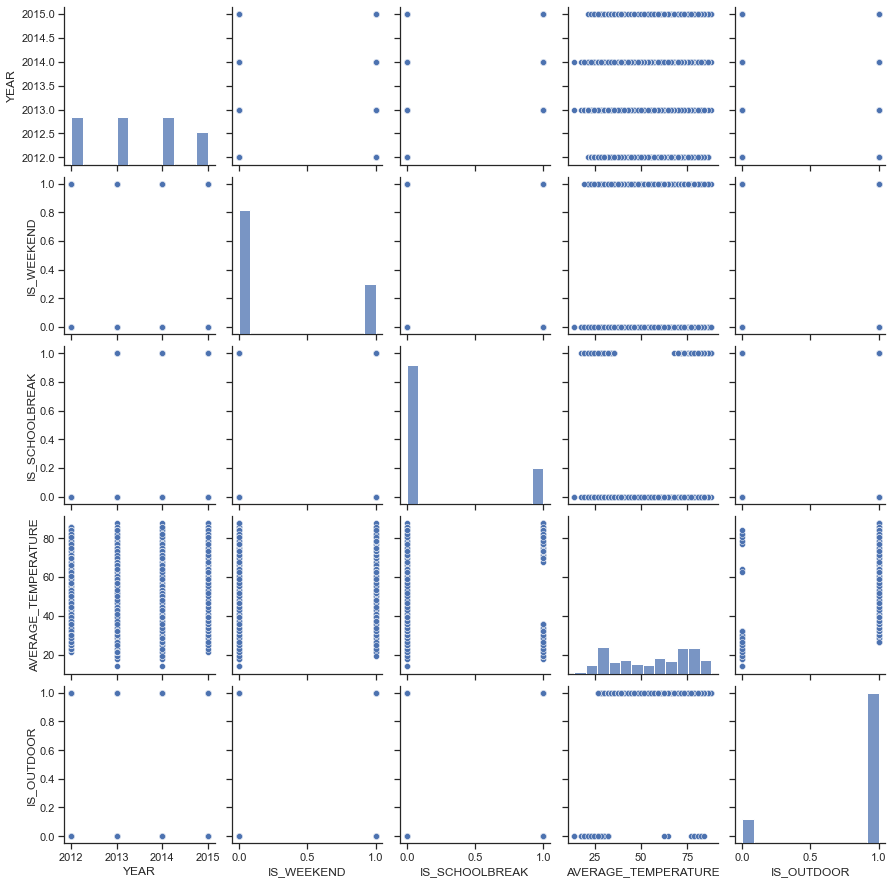

In [32]:
sns.pairplot(dateInfo_df)

#### getting the start and end date of the data

In [33]:
dateInfo_df['CALENDAR_DATE'].min()

'1/1/12'

In [34]:
dateInfo_df['CALENDAR_DATE'].max()

'9/9/15'

In [35]:
dateInfo_df.shape

(1349, 7)

In [36]:
# assigning dummies to ITEM_NAME values to examine how the sales (SELL_ID) were made
pd.concat([sold_df.SELL_ID, pd.get_dummies(sold_df.ITEM_NAME)], axis=1)

,SELL_ID,BURGER,COFFEE,COKE,LEMONADE
0,1070,1,0,0,0
1,3055,0,1,0,0
2,3067,0,0,1,0
3,3028,0,0,0,1
4,2051,1,0,0,0
5,2051,0,0,1,0
6,2052,1,0,0,0
7,2052,0,0,0,1
8,2053,1,0,0,0
9,2053,0,0,1,0


In [37]:
# assessing how the commodities were sold
pd.concat([sold_df.SELL_ID, pd.get_dummies(sold_df.ITEM_NAME)], axis=1).groupby(sold_df.SELL_ID).sum()

,SELL_ID,BURGER,COFFEE,COKE,LEMONADE
SELL_ID,,,,,
1070,1070,1,0,0,0
2051,4102,1,0,1,0
2052,4104,1,0,0,1
2053,6159,1,1,1,0
3028,3028,0,0,0,1
3055,3055,0,1,0,0
3067,3067,0,0,1,0


SELL_ID 1070, 3055, 3067 and 3028 represent single item sales while SELL_ID 2051, 2052, and 2053 represent more than one sale items.

In [38]:
# combining the sold and transactions dataframes dropping ITEM_ID and SELL_CATEGORY from the sold_df and transactions_df, resp
# as they are not that important for this analysis. SELL_CATEGORY was a repeat feature in the transactions_df dataframe 
combined_data = pd.merge(sold_df.drop(['ITEM_ID'],axis=1), transactions_df.drop(['SELL_CATEGORY'], axis= 1), on =  'SELL_ID')
combined_data.head(10)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY
0,1070,0,BURGER,01/01/12,15.5,46
1,1070,0,BURGER,01/02/12,15.5,70
2,1070,0,BURGER,01/03/12,15.5,62
3,1070,0,BURGER,01/04/12,15.5,88
4,1070,0,BURGER,01/05/12,15.5,104
5,1070,0,BURGER,01/06/12,15.5,100
6,1070,0,BURGER,01/07/12,15.5,70
7,1070,0,BURGER,01/08/12,15.5,70
8,1070,0,BURGER,01/09/12,15.5,106
9,1070,0,BURGER,01/10/12,15.5,108


In [39]:
# summing daily sold quantity by grouping into the other features
quantitySold = combined_data.groupby(['SELL_ID', 'SELL_CATEGORY', 'ITEM_NAME', 'CALENDAR_DATE','PRICE']).QUANTITY.sum()

In [40]:
quantitySold

SELL_ID  SELL_CATEGORY  ITEM_NAME  CALENDAR_DATE  PRICE
1070     0              BURGER     01/01/12       15.50    46
                                   01/01/13       15.50    60
                                   01/01/14       15.50    72
                                   01/01/15       14.00    66
                                   01/02/12       15.50    70
                                                           ..
2053     2              COKE       9/29/13        10.45    40
                                   9/29/14        12.77    46
                                   9/30/12        12.42    38
                                   9/30/13        10.45    38
                                   9/30/14        12.77    50
Name: QUANTITY, Length: 10792, dtype: int64

In [41]:
combined_data.shape

(10808, 6)

In [42]:
intermediate_data = quantitySold.reset_index()

In [43]:
intermediate_data.shape

(10792, 6)

In [44]:
intermediate_data.head(20)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY
0,1070,0,BURGER,01/01/12,15.5,46
1,1070,0,BURGER,01/01/13,15.5,60
2,1070,0,BURGER,01/01/14,15.5,72
3,1070,0,BURGER,01/01/15,14.0,66
4,1070,0,BURGER,01/02/12,15.5,70
5,1070,0,BURGER,01/02/13,15.5,68
6,1070,0,BURGER,01/02/14,15.5,76
7,1070,0,BURGER,01/02/15,14.0,102
8,1070,0,BURGER,01/03/12,15.5,62
9,1070,0,BURGER,01/03/13,15.5,70


In [45]:
intermediate_data.tail(20)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY
10772,2053,2,COKE,9/24/13,10.45,60
10773,2053,2,COKE,9/24/14,12.77,48
10774,2053,2,COKE,9/25/12,12.42,44
10775,2053,2,COKE,9/25/13,10.45,62
10776,2053,2,COKE,9/25/14,12.77,46
10777,2053,2,COKE,9/26/12,12.42,46
10778,2053,2,COKE,9/26/13,10.45,64
10779,2053,2,COKE,9/26/14,12.77,44
10780,2053,2,COKE,9/27/12,12.42,50
10781,2053,2,COKE,9/27/13,10.45,62


In [46]:
intermediate_data['CALENDAR_DATE'].min()

'01/01/12'

In [47]:
intermediate_data['CALENDAR_DATE'].max()

'9/30/14'

In [48]:
dateInfo_df.head()

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1/1/12,2012,New Year,1,0,24.8,0
1,1/2/12,2012,New Year,0,0,24.8,0
2,1/3/12,2012,New Year,0,0,32.0,1
3,1/4/12,2012,No Holiday,0,0,32.0,1
4,1/5/12,2012,No Holiday,0,0,24.8,0


#### recalling the date range for the dateInfo dataframe

In [49]:
dateInfo_df['CALENDAR_DATE'].min()

'1/1/12'

In [50]:
dateInfo_df['CALENDAR_DATE'].max()

'9/9/15'

It looks there is a year of data difference between the dateInfo_df and intermediate_data dataframes, and CALENDAR_DATE is the common feature to merge the two dataframes.

In [51]:
# combining the intermediate dataframe with the date_info dataframe using "CALENDAR_DATE" as a common feature
combined_data2 = pd.merge(intermediate_data, dateInfo_df, on = 'CALENDAR_DATE')
combined_data2.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,1/13/12,15.50,100,2012,No Holiday,0,0,26.6,0
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
2,2051,2,COKE,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
3,2052,2,BURGER,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
4,2052,2,LEMONADE,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0


In [52]:
# shape of the final combined data
combined_data2.shape

(6696, 12)

In [53]:
# checking if there is any missing data for the final combined data
combined_data2.isnull().sum()

SELL_ID                0
SELL_CATEGORY          0
ITEM_NAME              0
CALENDAR_DATE          0
PRICE                  0
QUANTITY               0
YEAR                   0
HOLIDAY                0
IS_WEEKEND             0
IS_SCHOOLBREAK         0
AVERAGE_TEMPERATURE    0
IS_OUTDOOR             0
dtype: int64

In [54]:
combined_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SELL_ID              6696 non-null   int64  
 1   SELL_CATEGORY        6696 non-null   int64  
 2   ITEM_NAME            6696 non-null   object 
 3   CALENDAR_DATE        6696 non-null   object 
 4   PRICE                6696 non-null   float64
 5   QUANTITY             6696 non-null   int64  
 6   YEAR                 6696 non-null   int64  
 7   HOLIDAY              6696 non-null   object 
 8   IS_WEEKEND           6696 non-null   int64  
 9   IS_SCHOOLBREAK       6696 non-null   int64  
 10  AVERAGE_TEMPERATURE  6696 non-null   float64
 11  IS_OUTDOOR           6696 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 680.1+ KB


In [55]:
# checking unique values in the HOLIDAY, IS_WEEKEND, IS_SCHOOLBREAK, and IS_OUTDOOR features
np.unique(combined_data2['HOLIDAY'])
np.unique(combined_data2['IS_WEEKEND'])
np.unique(combined_data2['IS_SCHOOLBREAK'])
np.unique(combined_data2['IS_OUTDOOR'])

array(['Dragon Boat Festivel', 'Labor Day', 'Luner New Year',
       'Mid-Autumn Day', 'No Holiday'], dtype=object)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

Perhaps, the different in distribution in price and quantity came due to differences in sales in the normal days and other days (i.e. weekends, schoolbreak, outdoor sales, etc). Therefore, it may be helpful to seprate the data for normal days and examine it further.

In [56]:
normalDays_data = combined_data2[(combined_data2['HOLIDAY']=='No Holiday') & (combined_data2['IS_SCHOOLBREAK']==0) & (combined_data2['IS_WEEKEND']==0)]

In [57]:
normalDays_data.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,1/13/12,15.50,100,2012,No Holiday,0,0,26.6,0
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
2,2051,2,COKE,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
3,2052,2,BURGER,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
4,2052,2,LEMONADE,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0


In [58]:
normalDays_data.shape

(3768, 12)

### exploring the normal days' sales data further

Burger has the highest sale, and coffee and Lemonade seems the least.

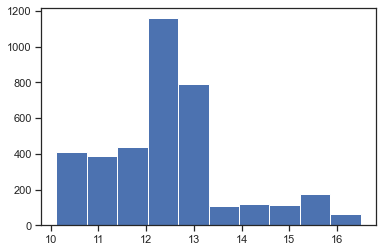

In [59]:
plt.hist(normalDays_data.PRICE);

Price still seems to have a bimodal distribution.

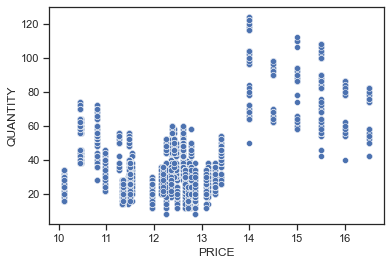

In [60]:
sns.scatterplot(combined_data2['PRICE'], combined_data2['QUANTITY']);

The scatterplot likewise shows two catagories of sales.

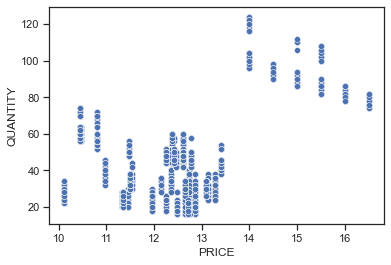

In [61]:
sns.scatterplot(normalDays_data['PRICE'],normalDays_data['QUANTITY']);

This shows that separating the normal days sales from the other days sales reduces density of the data in the upper right corner; however, still this shows the price distribution is not monomodal.

### exploring further to see if the sell price and quantity varies by item_name

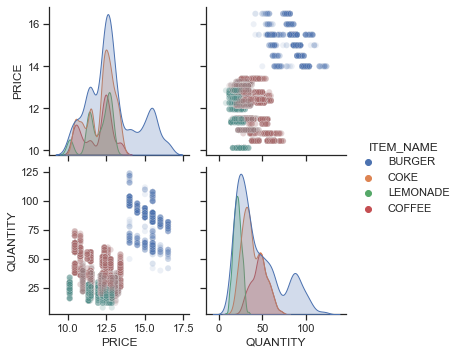

In [62]:
# pairplot for the full data
sns.pairplot(combined_data2[['PRICE','QUANTITY','ITEM_NAME']], hue = 'ITEM_NAME', plot_kws={'alpha':0.1});

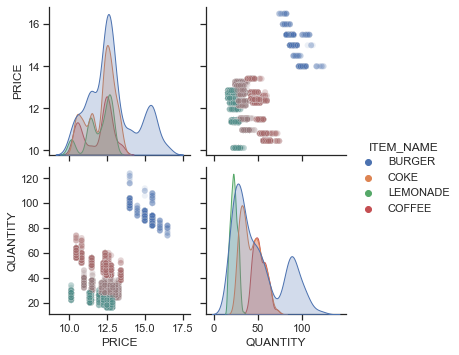

In [63]:
# pairplot for the normal days sales
sns.pairplot(normalDays_data[['PRICE','QUANTITY','ITEM_NAME']], hue = 'ITEM_NAME', plot_kws={'alpha':0.1});

Both pairplots shows that price has more than one distribution for most of the items. Although clustered largely in two groups, within the group, as price increases, quantity sold decreases.

#### estimating price for the different items

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,1/13/12,15.50,100,2012,No Holiday,0,0,26.6,0
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
3,2052,2,BURGER,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
5,2053,2,BURGER,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
8,1070,0,BURGER,1/13/13,15.50,70,2013,No Holiday,1,0,30.2,0


(3348, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,3348.000000,3348.000000,3348.000000,3348.000000,3348.000000,3348.000000,3348.000000,3348.000000,3348.000000
mean,1806.500000,1.500000,12.858572,44.974313,2013.351254,0.284349,0.200717,56.255914,0.878136
std,425.282579,0.866155,1.565046,25.747886,1.062567,0.451171,0.400596,19.996348,0.327177
min,1070.000000,0.000000,10.120000,8.000000,2012.000000,0.000000,0.000000,14.000000,0.000000
25%,1805.750000,1.500000,11.530000,24.000000,2012.000000,0.000000,0.000000,35.600000,1.000000
50%,2051.500000,2.000000,12.640000,36.000000,2013.000000,0.000000,0.000000,59.000000,1.000000
75%,2052.250000,2.000000,13.557500,60.000000,2014.000000,1.000000,0.000000,75.200000,1.000000
max,2053.000000,2.000000,16.500000,124.000000,2015.000000,1.000000,1.000000,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

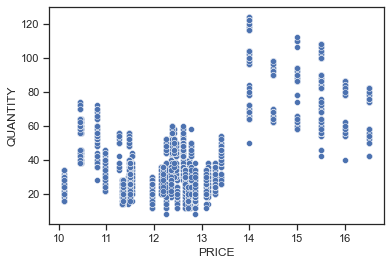

In [64]:
Burger = combined_data2[combined_data2['ITEM_NAME'] == 'BURGER']
Burger.head()
Burger.shape
Burger.describe()
sns.scatterplot(x = Burger.PRICE, y = Burger.QUANTITY )

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,1/13/12,15.50,100,2012,No Holiday,0,0,26.6,0
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
3,2052,2,BURGER,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
5,2053,2,BURGER,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
16,1070,0,BURGER,1/13/14,15.50,104,2014,No Holiday,0,0,28.4,0


(1884, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.0,1884.0,1884.000000,1884.000000
mean,1806.500000,1.500000,12.830340,49.562633,2013.186837,0.0,0.0,53.691720,0.883227
std,425.331956,0.866255,1.567257,27.309516,1.058620,0.0,0.0,18.721922,0.321235
min,1070.000000,0.000000,10.120000,16.000000,2012.000000,0.0,0.0,14.000000,0.000000
25%,1805.750000,1.500000,11.530000,28.000000,2012.000000,0.0,0.0,35.600000,1.000000
50%,2051.500000,2.000000,12.640000,40.000000,2013.000000,0.0,0.0,53.600000,1.000000
75%,2052.250000,2.000000,13.557500,74.000000,2014.000000,0.0,0.0,71.600000,1.000000
max,2053.000000,2.000000,16.500000,124.000000,2015.000000,0.0,0.0,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

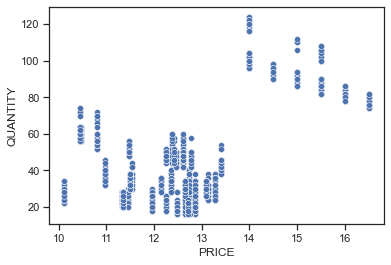

In [65]:
Burger = normalDays_data[normalDays_data['ITEM_NAME'] == 'BURGER']
Burger.head()
Burger.shape
Burger.describe()
sns.scatterplot(x = Burger.PRICE, y = Burger.QUANTITY )

The above two scatter plots suggest that there are clearly different types of burger distributions. Perhaps plotting the above distributions by SELL_ID may show some indications. If SELL ID differentiates the price distribution, it may be used to separate the data by SELL_ID and model its price elasticity accordingly. 

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

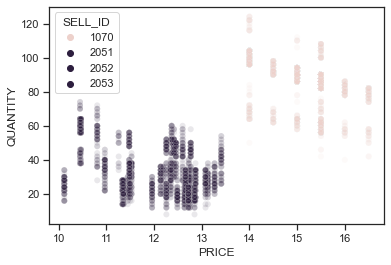

In [66]:
Burger = combined_data2[combined_data2['ITEM_NAME'] == 'BURGER']
sns.scatterplot(data = Burger, x = Burger.PRICE, y = Burger.QUANTITY , hue = 'SELL_ID', legend=True, alpha = 0.1)

Indeed, the price distribution varies by SELL_ID. For example, the scatter plots for SELL_ID 1070 are located more in right top corner while other SELL_IDs are at the bottom. 

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,1/13/12,15.50,100,2012,No Holiday,0,0,26.6,0
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
3,2052,2,BURGER,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
5,2053,2,BURGER,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
8,1070,0,BURGER,1/13/13,15.50,70,2013,No Holiday,1,0,30.2,0


,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,676.000000,676.000000,676.00000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,1806.500000,1.500000,12.83926,46.257396,2013.224852,0.278107,0.224852,40.723077,0.721893
std,425.533922,0.866667,1.51356,26.910199,0.996157,0.448398,0.417794,12.979245,0.448398
min,1070.000000,0.000000,10.12000,12.000000,2012.000000,0.000000,0.000000,17.600000,0.000000
25%,1805.750000,1.500000,12.25250,24.000000,2012.000000,0.000000,0.000000,28.400000,0.000000
50%,2051.500000,2.000000,12.74000,36.000000,2013.000000,0.000000,0.000000,39.200000,1.000000
75%,2052.250000,2.000000,13.55750,62.000000,2014.000000,1.000000,0.000000,51.800000,1.000000
max,2053.000000,2.000000,15.50000,122.000000,2015.000000,1.000000,1.000000,64.400000,1.000000


(676, 12)

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

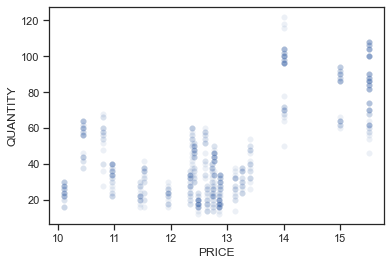

In [67]:
# examining the price distribution for burger SELL_ID 1070 for the full combined data
Burger_1070 = combined_data2[(combined_data2['ITEM_NAME'] == 'BURGER') & (combined_data['SELL_ID'] == 1070)]

Burger_1070.head()
Burger_1070.describe()
Burger_1070.shape
sns.scatterplot(data = Burger_1070, x = Burger_1070.PRICE, y = Burger_1070.QUANTITY, alpha = 0.1)

Still the Burger SELL_ID 1070 data shows highly spread data points with two or more clusters. Perhaps, it may be worth exploring the case for the normal days burger SELL_ID 1070 data

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,1/13/12,15.50,100,2012,No Holiday,0,0,26.6,0
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
3,2052,2,BURGER,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
5,2053,2,BURGER,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
16,1070,0,BURGER,1/13/14,15.50,104,2014,No Holiday,0,0,28.4,0


,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.0,372.0,372.000000,372.000000
mean,1806.500000,1.500000,12.795188,50.817204,2013.075269,0.0,0.0,43.709677,0.763441
std,425.791747,0.867192,1.538720,28.397238,0.942973,0.0,0.0,12.331679,0.425542
min,1070.000000,0.000000,10.120000,16.000000,2012.000000,0.0,0.0,23.000000,0.000000
25%,1805.750000,1.500000,12.350000,28.000000,2012.000000,0.0,0.0,32.000000,1.000000
50%,2051.500000,2.000000,12.730000,42.000000,2013.000000,0.0,0.0,46.400000,1.000000
75%,2052.250000,2.000000,13.452500,70.000000,2014.000000,0.0,0.0,53.600000,1.000000
max,2053.000000,2.000000,15.500000,122.000000,2015.000000,0.0,0.0,62.600000,1.000000


(372, 12)

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

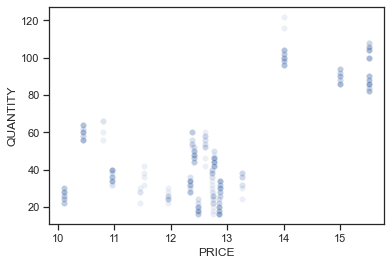

In [68]:
# examining the price distribution for burger SELL_ID 1070 for the normal days sales
Burger_1070N = normalDays_data[(normalDays_data['ITEM_NAME'] == 'BURGER') & (combined_data['SELL_ID'] == 1070)]

Burger_1070N.head()
Burger_1070N.describe()
Burger_1070N.shape
sns.scatterplot(data = Burger_1070N, x = Burger_1070N.PRICE, y = Burger_1070N.QUANTITY, alpha = 0.1)

Somehow, the price distribution for the SELL_ID 1070 burger during the normal days clustered more around one group compared to the case to the full combined data. This suggests that modeling the price elasticity using the normal days data may yield better fit compared to the full data.

### modeling price elasticity

#### modeling for burger sales

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     458.4
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           5.56e-78
Time:                        16:37:57   Log-Likelihood:                -3009.1
No. Observations:                 676   AIC:                             6022.
Df Residuals:                     674   BIC:                             6031.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -98.9790      6.831    -14.491      0.0

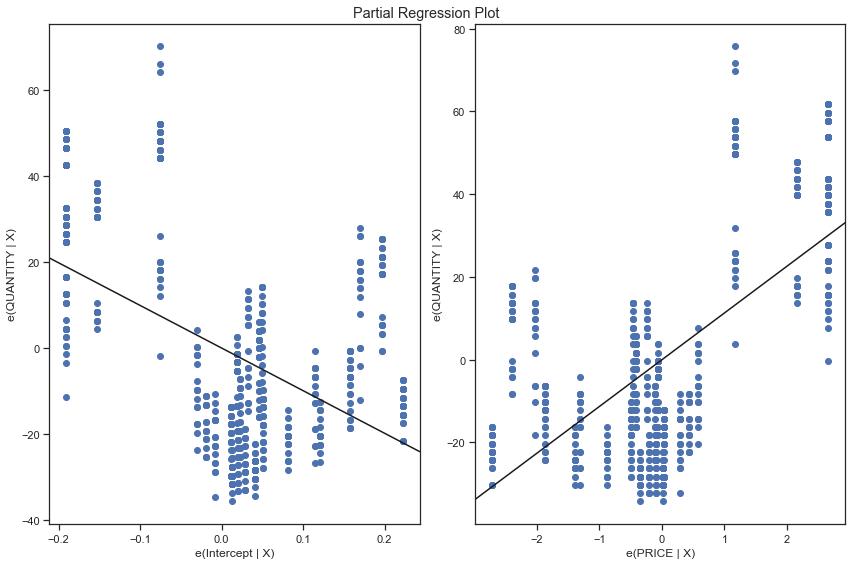

In [69]:
# modeling for burger of SELL_ID 1070 using the full combined data
burger_model = ols("QUANTITY ~ PRICE", data=Burger_1070).fit()
print(burger_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_model, fig=fig)

The model between price and quantity using the complete data provided an R-squared value of 0.405, which shows a poor fit. Moreover, there are two clusters of data (which, with in the group, seems to show a decrease in quantity with an increase in price). However, the regression line shows an increase in quantity sold with an increase in price, which is not logically possible. This suggests that modeling the normal days and other days (such as weekends, schoolbreak days) sales together may not yield a robust model.

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     302.7
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           5.78e-50
Time:                        16:38:16   Log-Likelihood:                -1661.0
No. Observations:                 372   AIC:                             3326.
Df Residuals:                     370   BIC:                             3334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -107.5819      9.170    -11.732      0.0

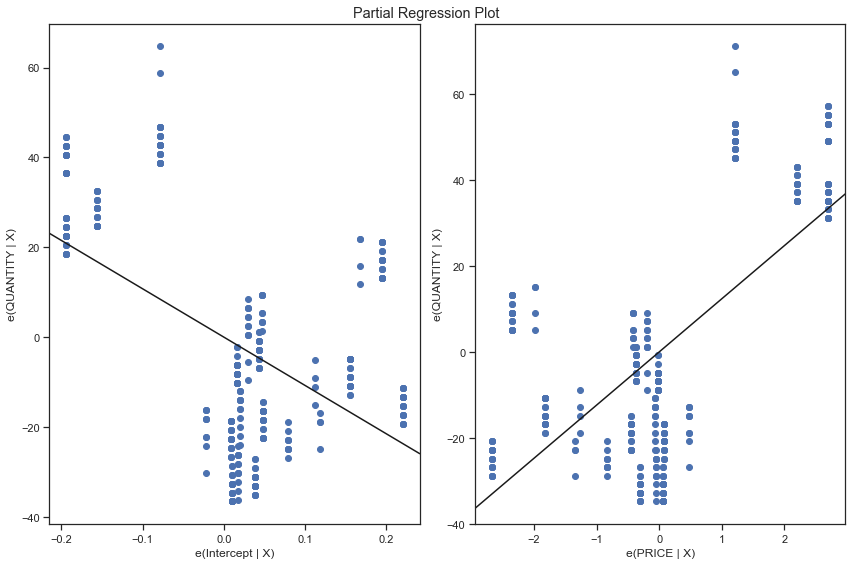

In [70]:
# modeling for burger of SELL_ID of 1070 using the normal day sales data
burger_modelN = ols("QUANTITY ~ PRICE", data=Burger_1070N).fit()
print(burger_modelN.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_modelN, fig=fig)

The R-squared improved a bit to 0.450 when modeling using only the normal days sales; however, still it is trying to connect the two clusters of data, which seems to be contrary to observation of the data (i.e. within the cluster groups there was a decrease in quantity sold with an increase in price). This all suggests the data requires further refinement to identify data clusters with similar unique characteristics/distributions. Perhaps, one option to consider could be further refining the data using the IS_OUTDOOR feature.

In [71]:
# modeling for burger of SELL_ID 1070 using the normal day sales data and refining the data further by IS_OUTDOOR sales data
np.unique(combined_data2["IS_OUTDOOR"])

array([0, 1], dtype=int64)

In [72]:
# modeling for burger of SELL_ID 1070 using the normal day sales data and refining the data further by IS_OUTDOOR sales data
normalDays_data2 = combined_data2[(combined_data2['HOLIDAY']=='No Holiday') & (combined_data2['IS_SCHOOLBREAK']==0) & (combined_data2['IS_WEEKEND']==0) & (combined_data2['IS_OUTDOOR']==1)]

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
48,1070,0,BURGER,1/14/14,15.5,86,2014,No Holiday,0,0,28.4,1
88,1070,0,BURGER,1/15/15,14.0,104,2015,No Holiday,0,0,32.0,1
120,1070,0,BURGER,1/16/15,14.0,100,2015,No Holiday,0,0,32.0,1
448,1070,0,BURGER,1/27/12,15.5,86,2012,No Holiday,0,0,32.0,1
576,1070,0,BURGER,1/31/12,15.5,84,2012,No Holiday,0,0,32.0,1


,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,416.0,416.0,416.000000,416.000000,416.000000,416.0,416.0,416.000000,416.0
mean,1070.0,0.0,15.139423,89.274038,2013.201923,0.0,0.0,57.282212,1.0
std,0.0,0.0,0.709511,6.811889,1.076628,0.0,0.0,16.890613,0.0
min,1070.0,0.0,14.000000,74.000000,2012.000000,0.0,0.0,26.600000,1.0
25%,1070.0,0.0,14.500000,84.000000,2012.000000,0.0,0.0,41.000000,1.0
50%,1070.0,0.0,15.000000,88.000000,2013.000000,0.0,0.0,59.000000,1.0
75%,1070.0,0.0,15.500000,94.000000,2014.000000,0.0,0.0,71.600000,1.0
max,1070.0,0.0,16.500000,104.000000,2015.000000,0.0,0.0,87.800000,1.0


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

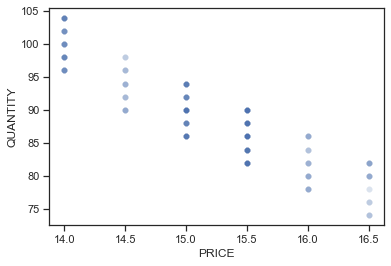

In [73]:
Burger_1070N2 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == 'BURGER') & (normalDays_data2['SELL_ID'] == 1070)]

Burger_1070N2.head()
Burger_1070N2.describe()
sns.scatterplot(data = Burger_1070N2, x = Burger_1070N2.PRICE, y = Burger_1070N2.QUANTITY, alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1804.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          5.51e-153
Time:                        16:38:37   Log-Likelihood:                -1038.8
No. Observations:                 416   AIC:                             2082.
Df Residuals:                     414   BIC:                             2090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    220.3600      3.090     71.322      0.0

<Figure size 864x576 with 0 Axes>

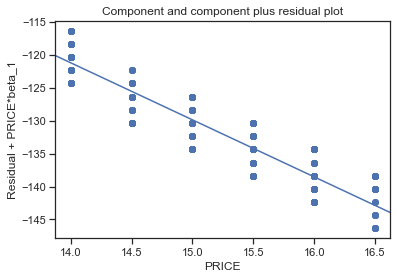

In [74]:
burger_modelN2 = ols("QUANTITY ~ PRICE", data=Burger_1070N2).fit()
print(burger_modelN2.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_ccpr(burger_modelN2, "PRICE")

Indeed, filitering the sales further by IS_OUTDOOR clusters the data into one group, which shows a decrease in quantity with an increase in price. This refinment in fact improved the model agreement to an R-squared value of 0.813. 

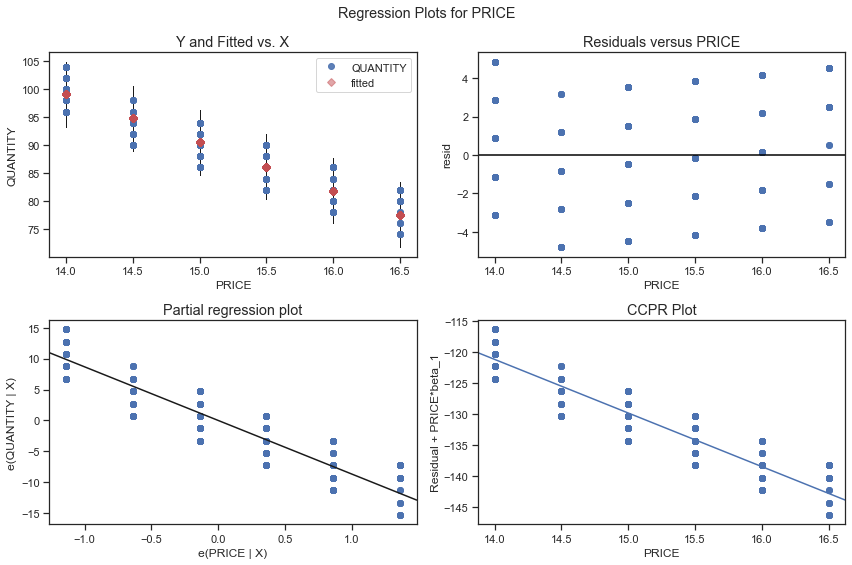

In [75]:
# plotting the above plot in different ways, i.e. using modelled, actual, and residual prices vs quantity
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(burger_modelN2, "PRICE", fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
9,2051,2,BURGER,1/13/13,13.13,26,2013,No Holiday,1,0,30.2,0
17,2051,2,BURGER,1/13/14,13.27,38,2014,No Holiday,0,0,28.4,0
25,2051,2,BURGER,1/13/15,11.53,38,2015,No Holiday,0,0,28.4,0
33,2051,2,BURGER,1/14/12,12.73,24,2012,No Holiday,1,0,23.0,0


,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,837.0,837.0,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,2051.0,2.0,12.368017,29.498208,2013.351254,0.284349,0.200717,56.255914,0.878136
std,0.0,0.0,0.726329,5.782878,1.063043,0.451373,0.400776,20.005316,0.327324
min,2051.0,2.0,10.970000,12.000000,2012.000000,0.000000,0.000000,14.000000,0.000000
25%,2051.0,2.0,11.530000,26.000000,2012.000000,0.000000,0.000000,35.600000,1.000000
50%,2051.0,2.0,12.660000,30.000000,2013.000000,0.000000,0.000000,59.000000,1.000000
75%,2051.0,2.0,13.080000,34.000000,2014.000000,1.000000,0.000000,75.200000,1.000000
max,2051.0,2.0,13.270000,46.000000,2015.000000,1.000000,1.000000,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

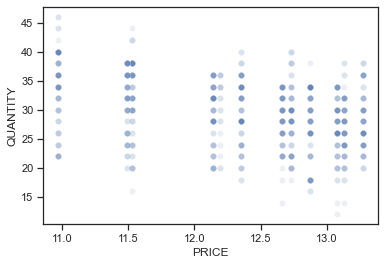

In [76]:
# modeling for Burger of SELL_ID 2051 using the complete (all) sales data
Burger_2051 = combined_data2[(combined_data2['ITEM_NAME'] == 'BURGER') & (combined_data2['SELL_ID'] == 2051)]

Burger_2051.head()
Burger_2051.describe()
sns.scatterplot(data = Burger_2051, x = Burger_2051.PRICE, y = Burger_2051.QUANTITY, alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     124.7
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           4.45e-27
Time:                        16:38:55   Log-Likelihood:                -2597.8
No. Observations:                 837   AIC:                             5200.
Df Residuals:                     835   BIC:                             5209.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.9906      3.184     20.411      0.0

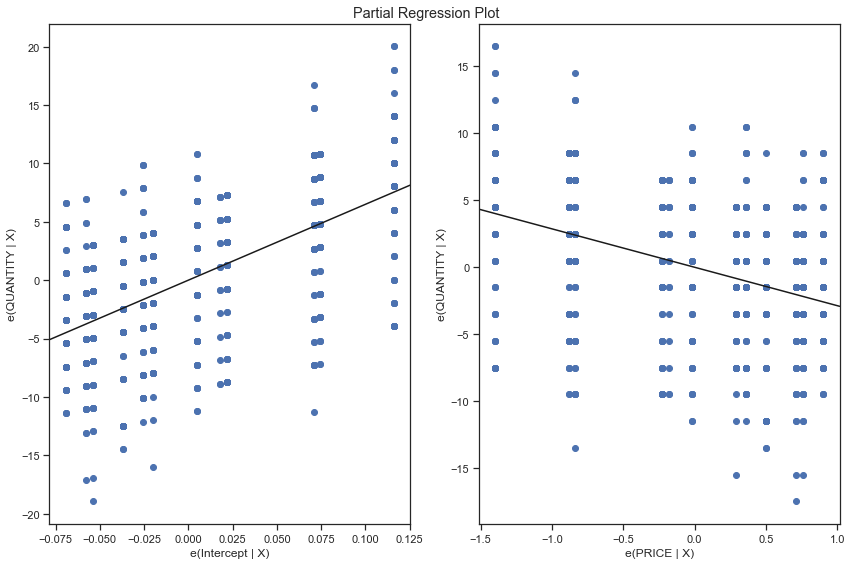

In [77]:
burger_model = ols("QUANTITY ~ PRICE", data=Burger_2051).fit()
print(burger_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_model, fig=fig)

The data is too spread and providing poor fit between the price and quantity.

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
1,2051,2,BURGER,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
17,2051,2,BURGER,1/13/14,13.27,38,2014,No Holiday,0,0,28.4,0
25,2051,2,BURGER,1/13/15,11.53,38,2015,No Holiday,0,0,28.4,0
49,2051,2,BURGER,1/14/14,13.27,24,2014,No Holiday,0,0,28.4,1
57,2051,2,BURGER,1/14/15,11.53,42,2015,No Holiday,0,0,30.2,0


,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,471.0,471.0,471.000000,471.000000,471.000000,471.0,471.0,471.000000,471.000000
mean,2051.0,2.0,12.322038,32.284501,2013.186837,0.0,0.0,53.691720,0.883227
std,0.0,0.0,0.742292,4.251127,1.059464,0.0,0.0,18.736854,0.321491
min,2051.0,2.0,10.970000,24.000000,2012.000000,0.0,0.0,14.000000,0.000000
25%,2051.0,2.0,11.530000,28.000000,2012.000000,0.0,0.0,35.600000,1.000000
50%,2051.0,2.0,12.660000,32.000000,2013.000000,0.0,0.0,53.600000,1.000000
75%,2051.0,2.0,12.870000,36.000000,2014.000000,0.0,0.0,70.700000,1.000000
max,2051.0,2.0,13.270000,46.000000,2015.000000,0.0,0.0,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

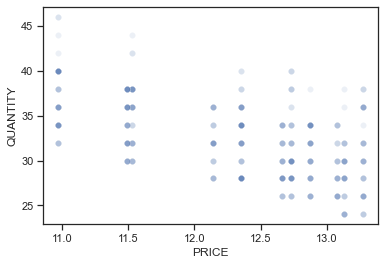

In [78]:
# modeling for another Burger of SELL_ID 2051 using the normal days sales data
Burger_2051N = normalDays_data[(normalDays_data['ITEM_NAME'] == 'BURGER') & (normalDays_data['SELL_ID'] == 2051)]

Burger_2051N.head()
Burger_2051N.describe()
sns.scatterplot(data = Burger_2051N, x = Burger_2051N.PRICE, y = Burger_2051N.QUANTITY, alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     238.9
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           7.43e-44
Time:                        16:39:06   Log-Likelihood:                -1252.5
No. Observations:                 471   AIC:                             2509.
Df Residuals:                     469   BIC:                             2517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.2801      2.657     27.579      0.0

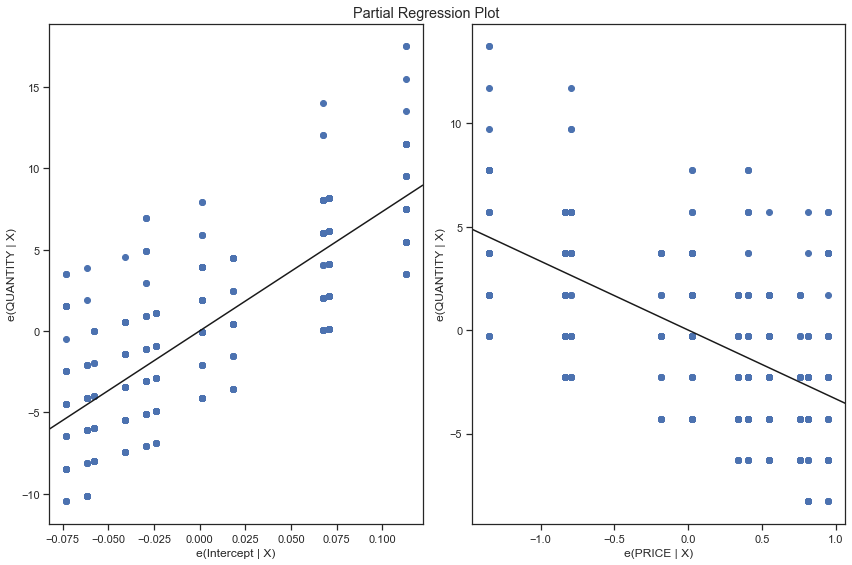

In [79]:
burger_modelN = ols("QUANTITY ~ PRICE", data=Burger_2051N).fit()
print(burger_modelN.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_modelN, fig=fig)

Focusing the analysis for the normal days sales improved the R-squared to 0.337, but the prediction was not satisfactory. Perhaps, considering separating the data by IS_OUTDOOR sales for the SELL_ID 2051 burger may improve it further, like the case for SELL_ID 1070 burger.

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
49,2051,2,BURGER,1/14/14,13.27,24,2014,No Holiday,0,0,28.4,1
89,2051,2,BURGER,1/15/15,11.53,36,2015,No Holiday,0,0,32.0,1
121,2051,2,BURGER,1/16/15,11.53,32,2015,No Holiday,0,0,32.0,1
449,2051,2,BURGER,1/27/12,12.73,28,2012,No Holiday,0,0,32.0,1
577,2051,2,BURGER,1/31/12,12.73,30,2012,No Holiday,0,0,32.0,1


,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,416.0,416.0,416.000000,416.000000,416.000000,416.0,416.0,416.000000,416.0
mean,2051.0,2.0,12.301562,31.620192,2013.201923,0.0,0.0,57.282212,1.0
std,0.0,0.0,0.730620,3.867688,1.076628,0.0,0.0,16.890613,0.0
min,2051.0,2.0,10.970000,24.000000,2012.000000,0.0,0.0,26.600000,1.0
25%,2051.0,2.0,11.530000,28.000000,2012.000000,0.0,0.0,41.000000,1.0
50%,2051.0,2.0,12.350000,32.000000,2013.000000,0.0,0.0,59.000000,1.0
75%,2051.0,2.0,12.870000,34.000000,2014.000000,0.0,0.0,71.600000,1.0
max,2051.0,2.0,13.270000,40.000000,2015.000000,0.0,0.0,87.800000,1.0


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

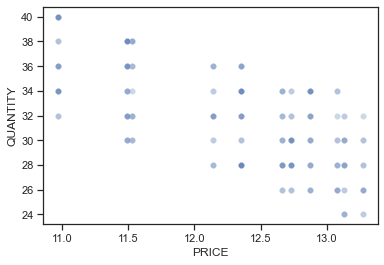

In [80]:
# modeling for another Burger of SELL_ID of 2051 using the normal days sales data and refined by IS_OUTDOOR sales
Burger_2051N2 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == 'BURGER') & (normalDays_data2['SELL_ID'] == 2051)]

Burger_2051N2.head()
Burger_2051N2.describe()
sns.scatterplot(data = Burger_2051N2, x = Burger_2051N2.PRICE, y = Burger_2051N2.QUANTITY, alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     363.3
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           1.34e-58
Time:                        16:39:16   Log-Likelihood:                -1021.5
No. Observations:                 416   AIC:                             2047.
Df Residuals:                     414   BIC:                             2055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.1394      2.340     32.540      0.0

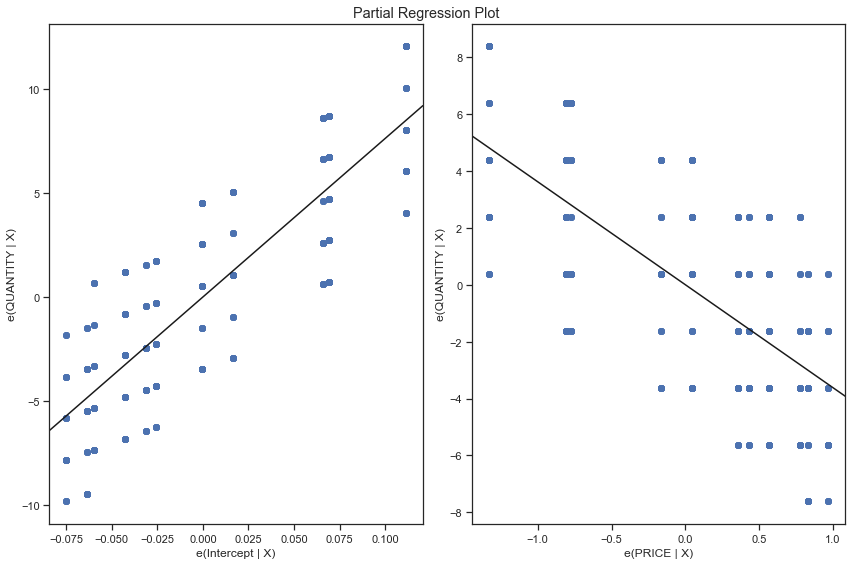

In [81]:
burger_modelN2 = ols("QUANTITY ~ PRICE", data=Burger_2051N2).fit()
print(burger_modelN2.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_modelN2, fig=fig)

Like the case for burger SELL_ID of 1070, the model fit for the burger SELL_ID of 2051 improves when it was refined for normal days (i.e. excluding weekends and school breaks) and by IS_OUTDOOR.

#### modeling for coke sales 

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
2,2051,2,COKE,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
7,2053,2,COKE,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
10,2051,2,COKE,1/13/13,13.13,26,2013,No Holiday,1,0,30.2,0
15,2053,2,COKE,1/13/13,13.41,32,2013,No Holiday,1,0,30.2,0
18,2051,2,COKE,1/13/14,13.27,38,2014,No Holiday,0,0,28.4,0


(1674, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,1674.000000,1674.0,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000
mean,2052.000000,2.0,12.151326,38.150538,2013.351254,0.284349,0.200717,56.255914,0.878136
std,1.000299,0.0,0.871405,11.861375,1.062726,0.451239,0.400656,19.999336,0.327226
min,2051.000000,2.0,10.450000,12.000000,2012.000000,0.000000,0.000000,14.000000,0.000000
25%,2051.000000,2.0,11.490000,30.000000,2012.000000,0.000000,0.000000,35.600000,1.000000
50%,2052.000000,2.0,12.370000,36.000000,2013.000000,0.000000,0.000000,59.000000,1.000000
75%,2053.000000,2.0,12.770000,48.000000,2014.000000,1.000000,0.000000,75.200000,1.000000
max,2053.000000,2.0,13.410000,74.000000,2015.000000,1.000000,1.000000,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

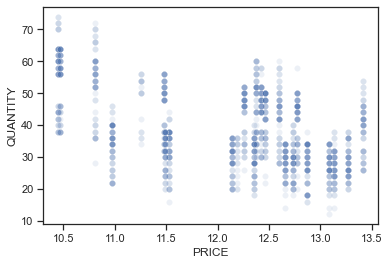

In [82]:
# modeling for the complete sales data for coke
Coke = combined_data2[combined_data2['ITEM_NAME'] == 'COKE']
Coke.head()
Coke.shape
Coke.describe()
sns.scatterplot(x = Coke.PRICE, y = Coke.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     544.2
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          1.94e-104
Time:                        16:39:27   Log-Likelihood:                -6279.2
No. Observations:                1674   AIC:                         1.256e+04
Df Residuals:                    1672   BIC:                         1.257e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    120.1140      3.522     34.100      0.0

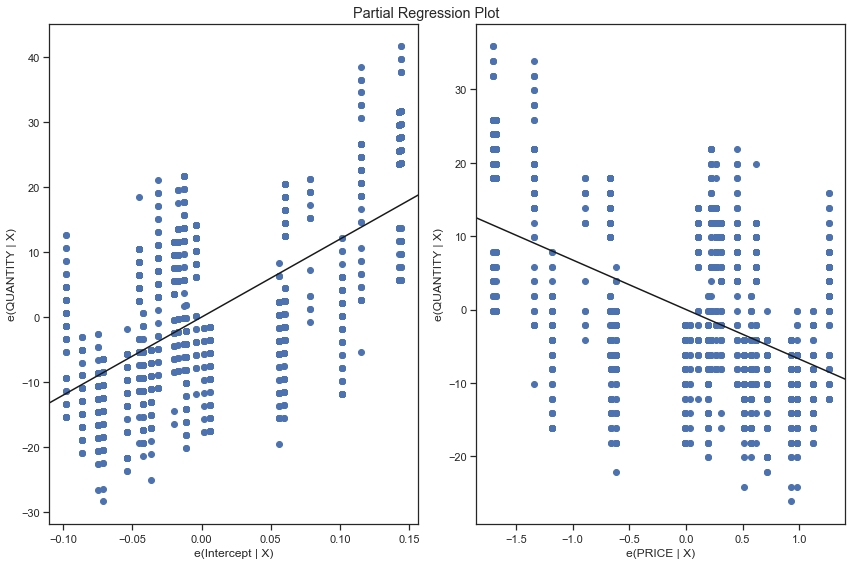

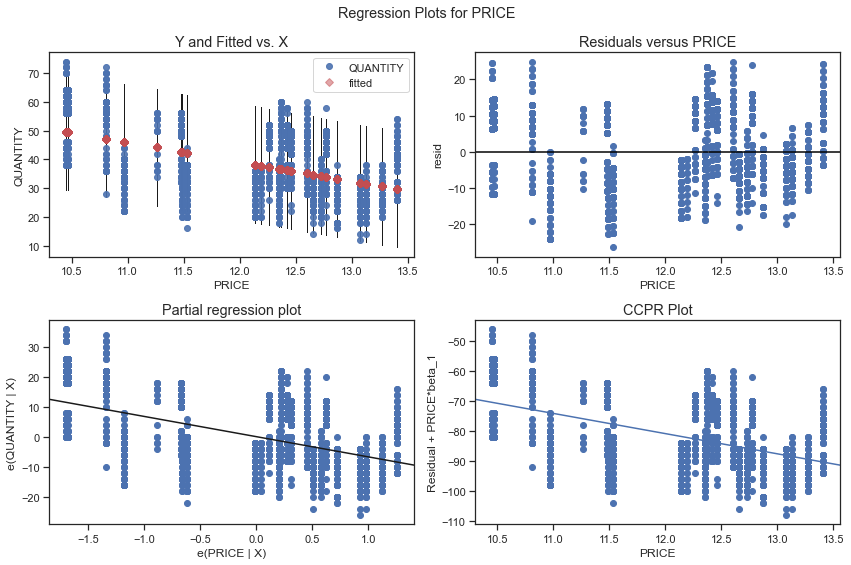

In [83]:
coke_model = ols("QUANTITY ~ PRICE", data=Coke).fit()
print(coke_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(coke_model, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(coke_model, 'PRICE', fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
2,2051,2,COKE,1/13/12,12.73,40,2012,No Holiday,0,0,26.6,0
7,2053,2,COKE,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
18,2051,2,COKE,1/13/14,13.27,38,2014,No Holiday,0,0,28.4,0
23,2053,2,COKE,1/13/14,12.37,60,2014,No Holiday,0,0,28.4,0
26,2051,2,COKE,1/13/15,11.53,38,2015,No Holiday,0,0,28.4,0


(942, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,942.000000,942.0,942.000000,942.000000,942.000000,942.0,942.0,942.000000,942.000000
mean,2052.000000,2.0,12.114745,42.074310,2013.186837,0.0,0.0,53.691720,0.883227
std,1.000531,0.0,0.890411,11.480372,1.058901,0.0,0.0,18.726896,0.321320
min,2051.000000,2.0,10.450000,24.000000,2012.000000,0.0,0.0,14.000000,0.000000
25%,2051.000000,2.0,11.490000,32.000000,2012.000000,0.0,0.0,35.600000,1.000000
50%,2052.000000,2.0,12.370000,40.000000,2013.000000,0.0,0.0,53.600000,1.000000
75%,2053.000000,2.0,12.730000,50.000000,2014.000000,0.0,0.0,71.150000,1.000000
max,2053.000000,2.0,13.410000,74.000000,2015.000000,0.0,0.0,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

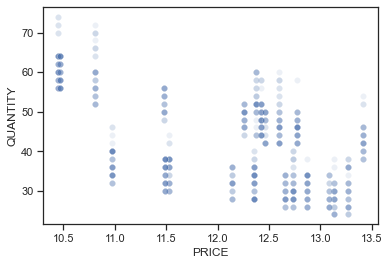

In [84]:
# modeling for the normal days sales data for coke
CokeN = normalDays_data[normalDays_data['ITEM_NAME'] == 'COKE']
CokeN.head()
CokeN.shape
CokeN.describe()
sns.scatterplot(x = CokeN.PRICE, y = CokeN.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     459.3
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           2.83e-83
Time:                        16:39:46   Log-Likelihood:                -3447.8
No. Observations:                 942   AIC:                             6900.
Df Residuals:                     940   BIC:                             6909.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    131.5622      4.187     31.422      0.0

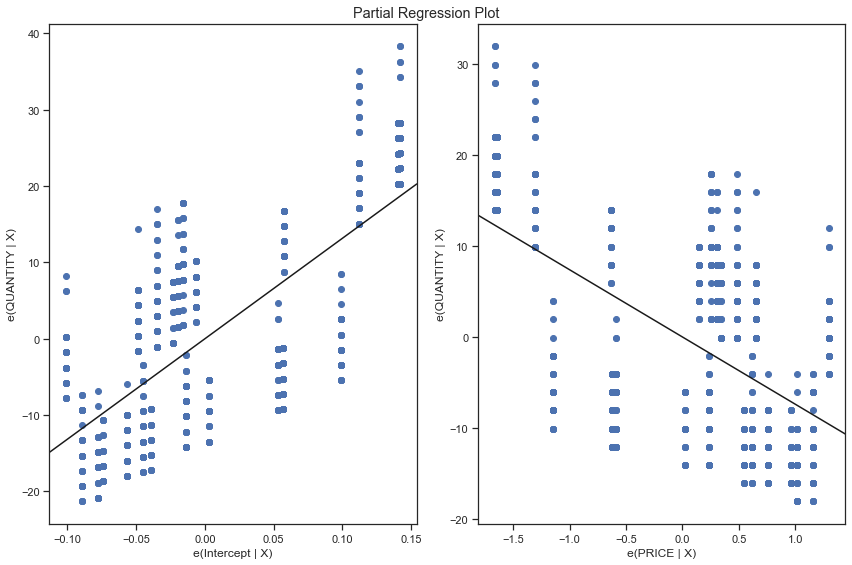

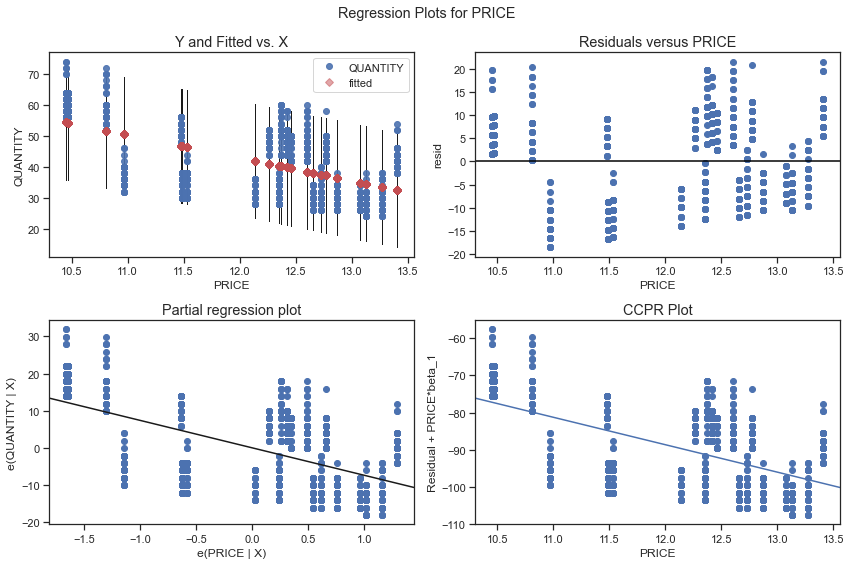

In [85]:
coke_modelN = ols("QUANTITY ~ PRICE", data=CokeN).fit()
print(coke_modelN.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(coke_modelN, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(coke_modelN, 'PRICE', fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
50,2051,2,COKE,1/14/14,13.27,24,2014,No Holiday,0,0,28.4,1
55,2053,2,COKE,1/14/14,12.37,52,2014,No Holiday,0,0,28.4,1
90,2051,2,COKE,1/15/15,11.53,36,2015,No Holiday,0,0,32.0,1
95,2053,2,COKE,1/15/15,10.81,56,2015,No Holiday,0,0,32.0,1
122,2051,2,COKE,1/16/15,11.53,32,2015,No Holiday,0,0,32.0,1


(832, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,832.000000,832.0,832.000000,832.000000,832.000000,832.0,832.0,832.000000,832.0
mean,2052.000000,2.0,12.097644,41.223558,2013.201923,0.0,0.0,57.282212,1.0
std,1.000602,0.0,0.889572,11.064542,1.075980,0.0,0.0,16.880447,0.0
min,2051.000000,2.0,10.450000,24.000000,2012.000000,0.0,0.0,26.600000,1.0
25%,2051.000000,2.0,11.490000,32.000000,2012.000000,0.0,0.0,41.000000,1.0
50%,2052.000000,2.0,12.370000,40.000000,2013.000000,0.0,0.0,59.000000,1.0
75%,2053.000000,2.0,12.730000,50.000000,2014.000000,0.0,0.0,71.600000,1.0
max,2053.000000,2.0,13.410000,64.000000,2015.000000,0.0,0.0,87.800000,1.0


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

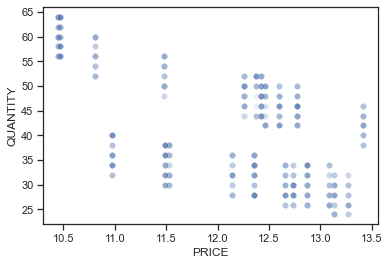

In [86]:
# considering the normal days sales and outdoor sales data considerations for the analysis
CokeN2 = normalDays_data2[normalDays_data2['ITEM_NAME'] == 'COKE']
CokeN2.head()
CokeN2.shape
CokeN2.describe()
sns.scatterplot(x = CokeN2.PRICE, y = CokeN2.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     466.3
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           2.00e-82
Time:                        16:40:03   Log-Likelihood:                -2994.5
No. Observations:                 832   AIC:                             5993.
Df Residuals:                     830   BIC:                             6002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    131.4732      4.190     31.374      0.0

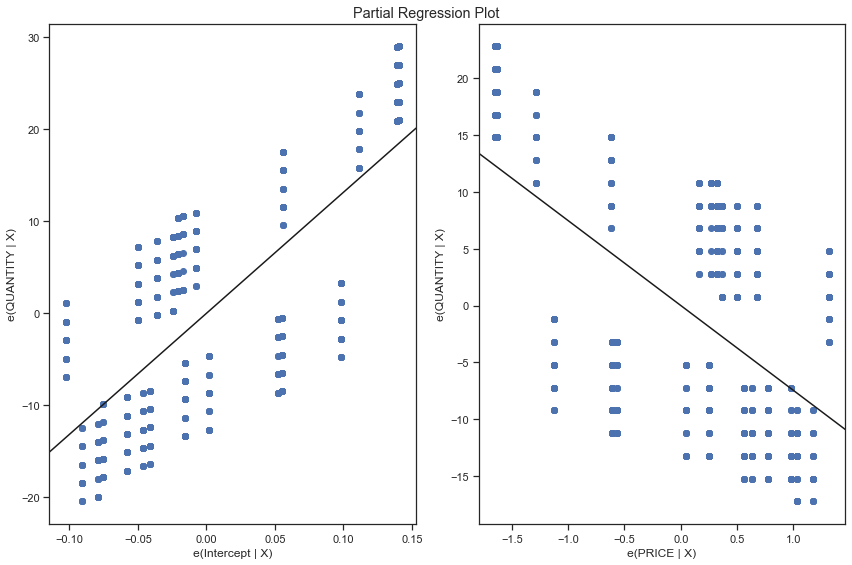

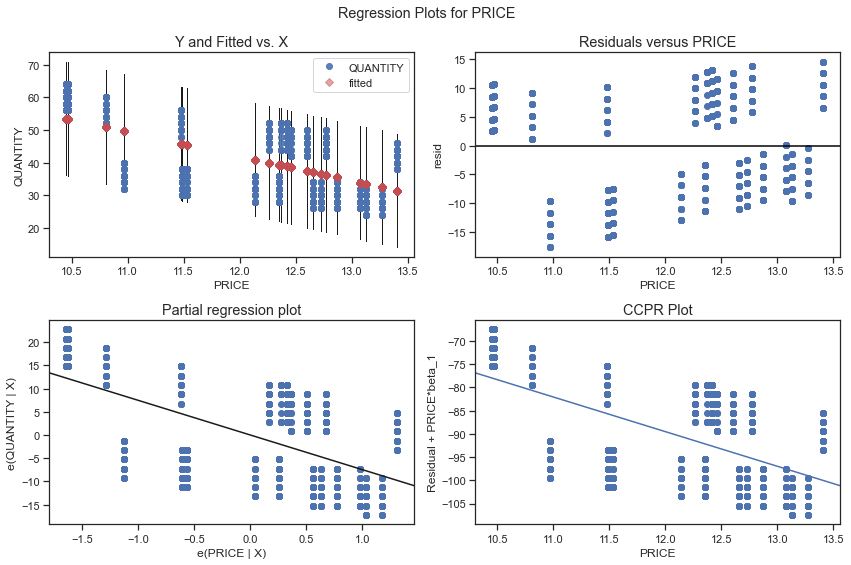

In [87]:
coke_modelN2 = ols("QUANTITY ~ PRICE", data=CokeN2).fit()
print(coke_modelN2.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(coke_modelN2, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(coke_modelN2, 'PRICE', fig=fig)

Like the burger sales, developing models, disaggregating the sales data by normal days and other days (i.e., weekend and schoolbreaks) and further refining by IS_OUTDOOR improved the model fit successively.

#### modeling for coffee sales

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
6,2053,2,COFFEE,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
14,2053,2,COFFEE,1/13/13,13.41,32,2013,No Holiday,1,0,30.2,0
22,2053,2,COFFEE,1/13/14,12.37,60,2014,No Holiday,0,0,28.4,0
30,2053,2,COFFEE,1/13/15,10.81,66,2015,No Holiday,0,0,28.4,0
38,2053,2,COFFEE,1/14/12,12.60,42,2012,No Holiday,1,0,23.0,0


(837, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,837.0,837.0,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,2053.0,2.0,11.934636,46.802867,2013.351254,0.284349,0.200717,56.255914,0.878136
std,0.0,0.0,0.947643,9.909910,1.063043,0.451373,0.400776,20.005316,0.327324
min,2053.0,2.0,10.450000,20.000000,2012.000000,0.000000,0.000000,14.000000,0.000000
25%,2053.0,2.0,10.810000,40.000000,2012.000000,0.000000,0.000000,35.600000,1.000000
50%,2053.0,2.0,12.370000,48.000000,2013.000000,0.000000,0.000000,59.000000,1.000000
75%,2053.0,2.0,12.600000,54.000000,2014.000000,1.000000,0.000000,75.200000,1.000000
max,2053.0,2.0,13.410000,74.000000,2015.000000,1.000000,1.000000,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

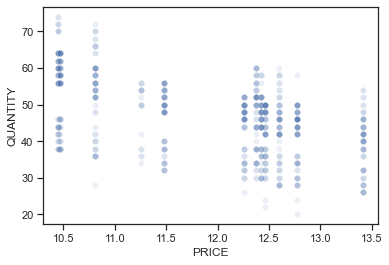

In [88]:
# modeling for coffee using the full sales data
Coffee = combined_data2[combined_data2['ITEM_NAME'] == 'COFFEE']
Coffee.head()
Coffee.shape
Coffee.describe()
sns.scatterplot(x = Coffee.PRICE, y = Coffee.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     327.0
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           6.20e-62
Time:                        16:40:13   Log-Likelihood:                -2968.5
No. Observations:                 837   AIC:                             5941.
Df Residuals:                     835   BIC:                             5951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.0116      3.673     30.770      0.0

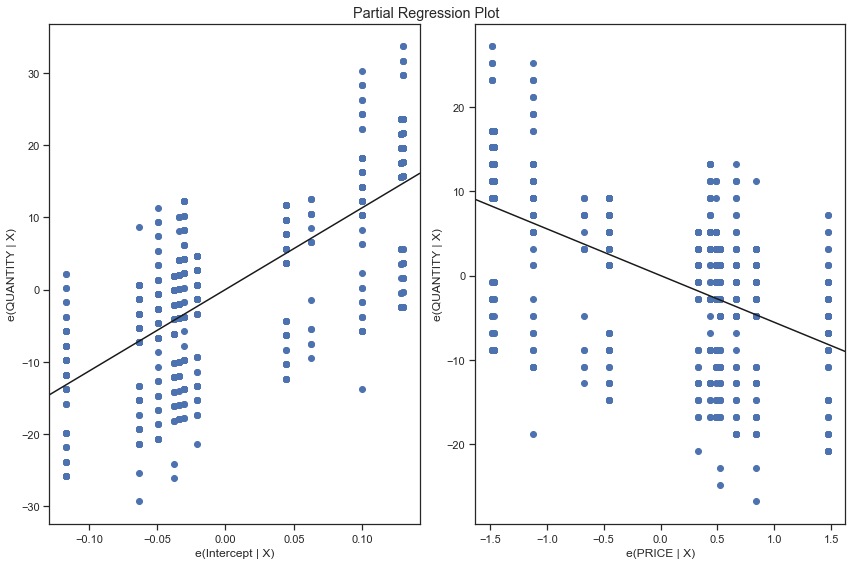

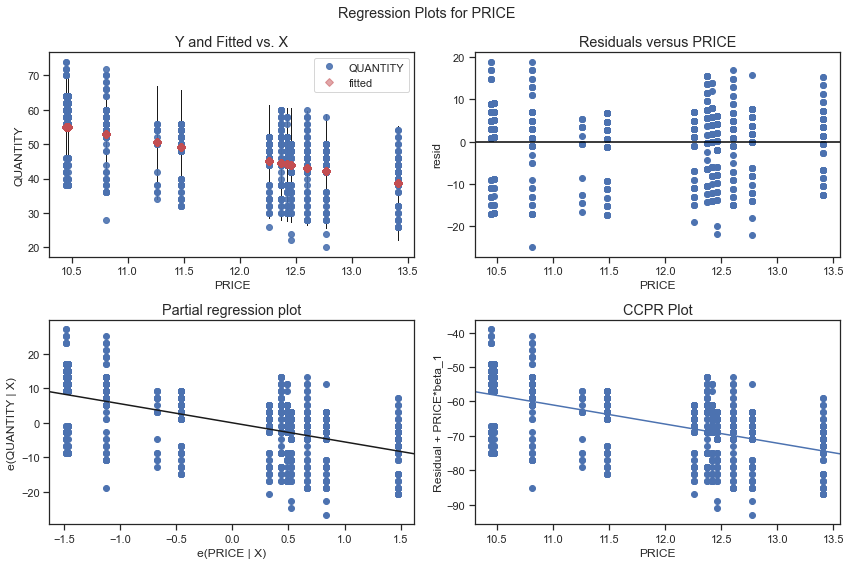

In [89]:
model_coffee = ols("QUANTITY ~ PRICE", data=Coffee).fit()
print(model_coffee.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model_coffee, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_coffee, 'PRICE', fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
6,2053,2,COFFEE,1/13/12,12.60,58,2012,No Holiday,0,0,26.6,0
22,2053,2,COFFEE,1/13/14,12.37,60,2014,No Holiday,0,0,28.4,0
30,2053,2,COFFEE,1/13/15,10.81,66,2015,No Holiday,0,0,28.4,0
54,2053,2,COFFEE,1/14/14,12.37,52,2014,No Holiday,0,0,28.4,1
62,2053,2,COFFEE,1/14/15,10.81,66,2015,No Holiday,0,0,30.2,0


(471, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,471.0,471.0,471.000000,471.000000,471.000000,471.0,471.0,471.000000,471.000000
mean,2053.0,2.0,11.907452,51.864119,2013.186837,0.0,0.0,53.691720,0.883227
std,0.0,0.0,0.974797,7.329234,1.059464,0.0,0.0,18.736854,0.321491
min,2053.0,2.0,10.450000,38.000000,2012.000000,0.0,0.0,14.000000,0.000000
25%,2053.0,2.0,10.810000,46.000000,2012.000000,0.0,0.0,35.600000,1.000000
50%,2053.0,2.0,12.370000,50.000000,2013.000000,0.0,0.0,53.600000,1.000000
75%,2053.0,2.0,12.600000,58.000000,2014.000000,0.0,0.0,70.700000,1.000000
max,2053.0,2.0,13.410000,74.000000,2015.000000,0.0,0.0,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

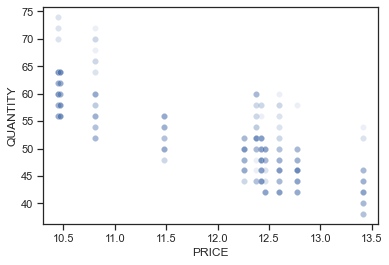

In [90]:
# modeling for coffee sales using the normal days for the analysis
CoffeeN = normalDays_data[normalDays_data['ITEM_NAME'] == 'COFFEE']
CoffeeN.head()
CoffeeN.shape
CoffeeN.describe()
sns.scatterplot(x = CoffeeN.PRICE, y = CoffeeN.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     929.6
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          2.38e-113
Time:                        16:40:26   Log-Likelihood:                -1348.7
No. Observations:                 471   AIC:                             2701.
Df Residuals:                     469   BIC:                             2710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.8547      2.402     51.981      0.0

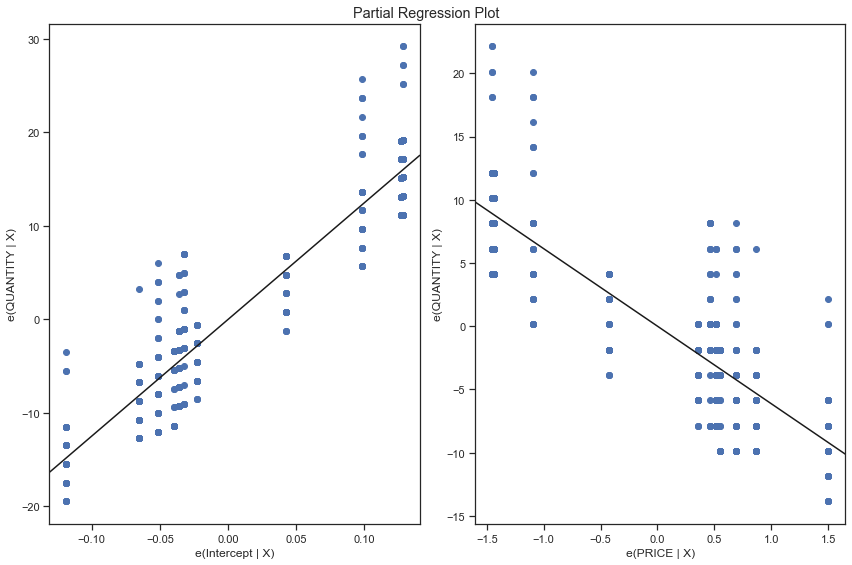

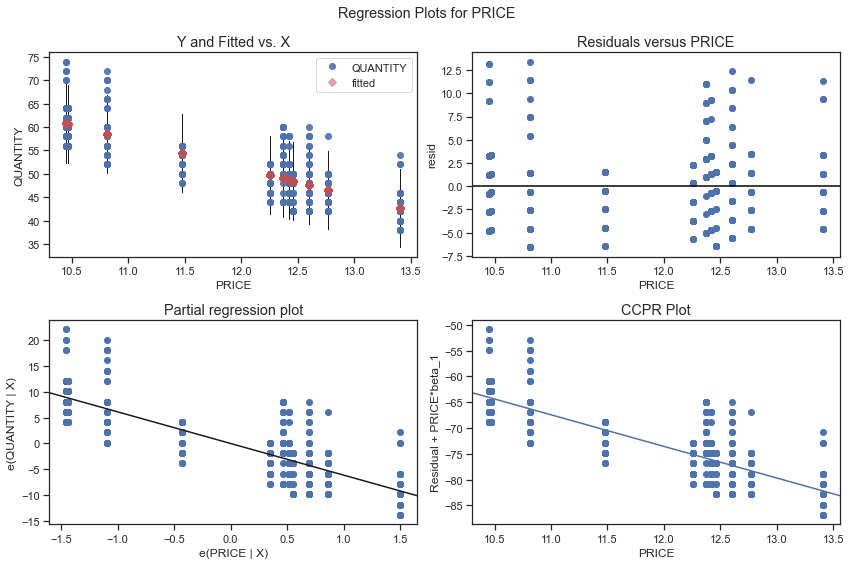

In [91]:
model_coffeeN = ols("QUANTITY ~ PRICE", data=CoffeeN).fit()
print(model_coffeeN.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model_coffeeN, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_coffeeN, 'PRICE', fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
54,2053,2,COFFEE,1/14/14,12.37,52,2014,No Holiday,0,0,28.4,1
94,2053,2,COFFEE,1/15/15,10.81,56,2015,No Holiday,0,0,32.0,1
126,2053,2,COFFEE,1/16/15,10.81,60,2015,No Holiday,0,0,32.0,1
454,2053,2,COFFEE,1/27/12,12.60,46,2012,No Holiday,0,0,32.0,1
582,2053,2,COFFEE,1/31/12,12.60,42,2012,No Holiday,0,0,32.0,1


(416, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,416.0,416.0,416.000000,416.000000,416.000000,416.0,416.0,416.000000,416.0
mean,2053.0,2.0,11.893726,50.826923,2013.201923,0.0,0.0,57.282212,1.0
std,0.0,0.0,0.983571,6.729818,1.076628,0.0,0.0,16.890613,0.0
min,2053.0,2.0,10.450000,38.000000,2012.000000,0.0,0.0,26.600000,1.0
25%,2053.0,2.0,10.810000,46.000000,2012.000000,0.0,0.0,41.000000,1.0
50%,2053.0,2.0,12.370000,50.000000,2013.000000,0.0,0.0,59.000000,1.0
75%,2053.0,2.0,12.600000,56.000000,2014.000000,0.0,0.0,71.600000,1.0
max,2053.0,2.0,13.410000,64.000000,2015.000000,0.0,0.0,87.800000,1.0


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

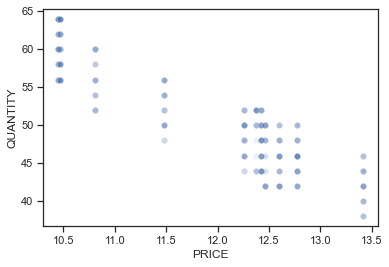

In [92]:
# considering sales data during the normal days considering sales outdoor for the analysis
CoffeeN2 = normalDays_data2[normalDays_data2['ITEM_NAME'] == 'COFFEE']
CoffeeN2.head()
CoffeeN2.shape
CoffeeN2.describe()
sns.scatterplot(x = CoffeeN2.PRICE, y = CoffeeN2.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          3.72e-152
Time:                        16:40:42   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.1417      1.742     71.270      0.0

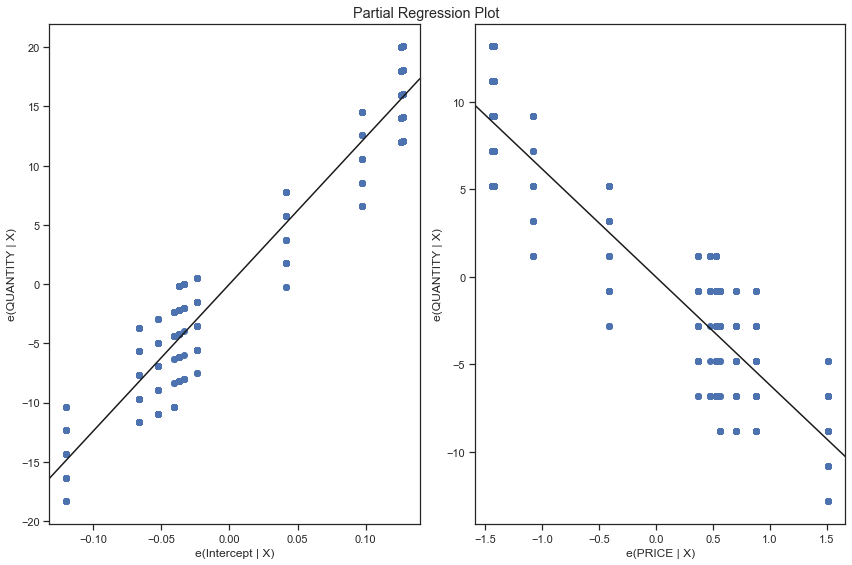

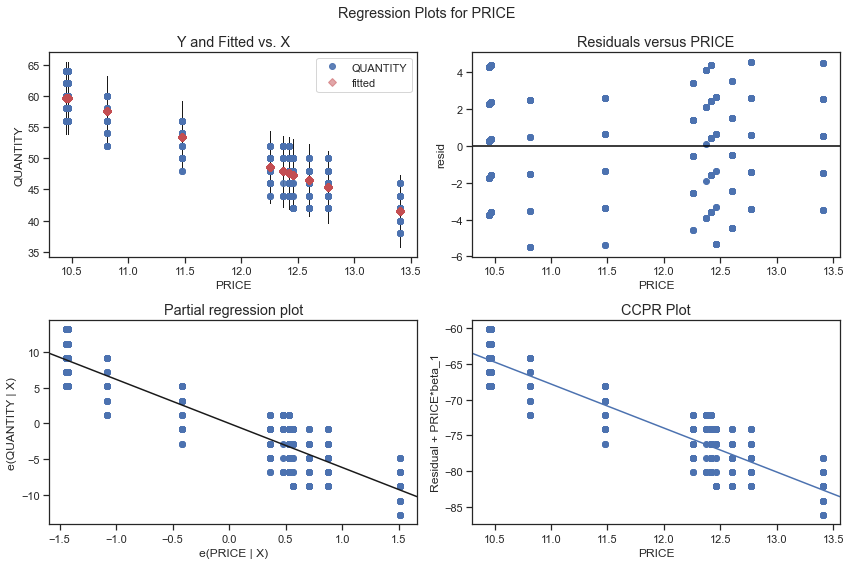

In [93]:
model_coffeeN2 = ols("QUANTITY ~ PRICE", data=CoffeeN2).fit()
print(model_coffeeN2.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model_coffeeN2, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_coffeeN2, 'PRICE', fig=fig)

Separating the sales data by normal days and other days (i.e, weekend and school breaks sales) improved the model fit. Likewise, further refinement by outdoor sales improved the model fit.

#### modeling for the Lemonade sales 

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
4,2052,2,LEMONADE,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
12,2052,2,LEMONADE,1/13/13,12.64,18,2013,No Holiday,1,0,30.2,0
20,2052,2,LEMONADE,1/13/14,11.96,24,2014,No Holiday,0,0,28.4,0
28,2052,2,LEMONADE,1/13/15,11.45,28,2015,No Holiday,0,0,28.4,0
36,2052,2,LEMONADE,1/14/12,12.75,20,2012,No Holiday,1,0,23.0,0


(837, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,837.0,837.0,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,2052.0,2.0,11.976918,20.910394,2013.351254,0.284349,0.200717,56.255914,0.878136
std,0.0,0.0,0.820698,4.514501,1.063043,0.451373,0.400776,20.005316,0.327324
min,2052.0,2.0,10.120000,8.000000,2012.000000,0.000000,0.000000,14.000000,0.000000
25%,2052.0,2.0,11.360000,18.000000,2012.000000,0.000000,0.000000,35.600000,1.000000
50%,2052.0,2.0,12.260000,20.000000,2013.000000,0.000000,0.000000,59.000000,1.000000
75%,2052.0,2.0,12.720000,24.000000,2014.000000,1.000000,0.000000,75.200000,1.000000
max,2052.0,2.0,12.850000,34.000000,2015.000000,1.000000,1.000000,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

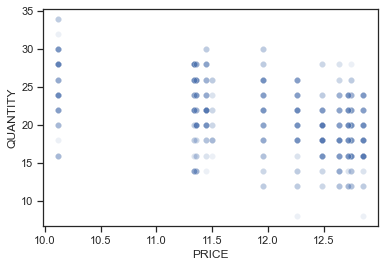

In [94]:
# considering all the sales data for the analysis
Lemonade = combined_data2[combined_data2['ITEM_NAME'] == 'LEMONADE']
Lemonade.head()
Lemonade.shape
Lemonade.describe()
sns.scatterplot(x = Lemonade.PRICE, y = Lemonade.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     228.7
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           7.46e-46
Time:                        16:40:54   Log-Likelihood:                -2347.4
No. Observations:                 837   AIC:                             4699.
Df Residuals:                     835   BIC:                             4708.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.4615      2.025     25.416      0.0

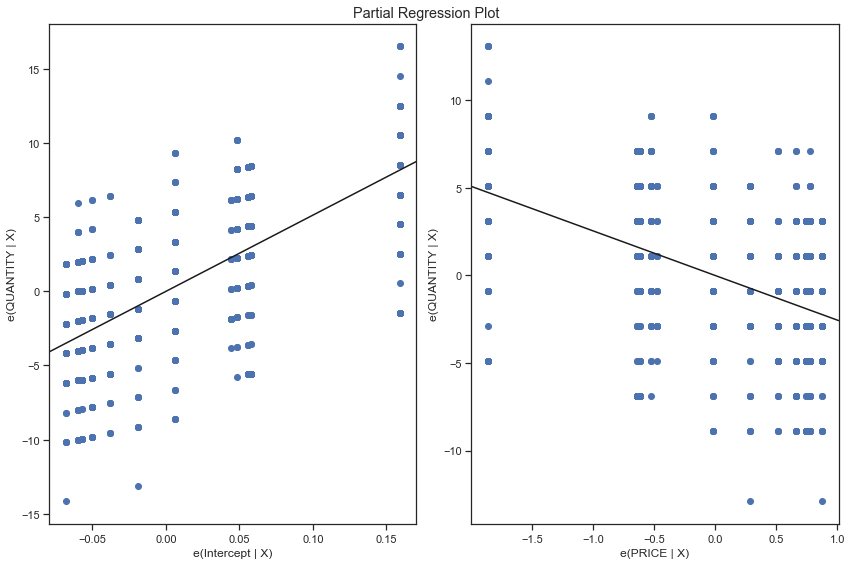

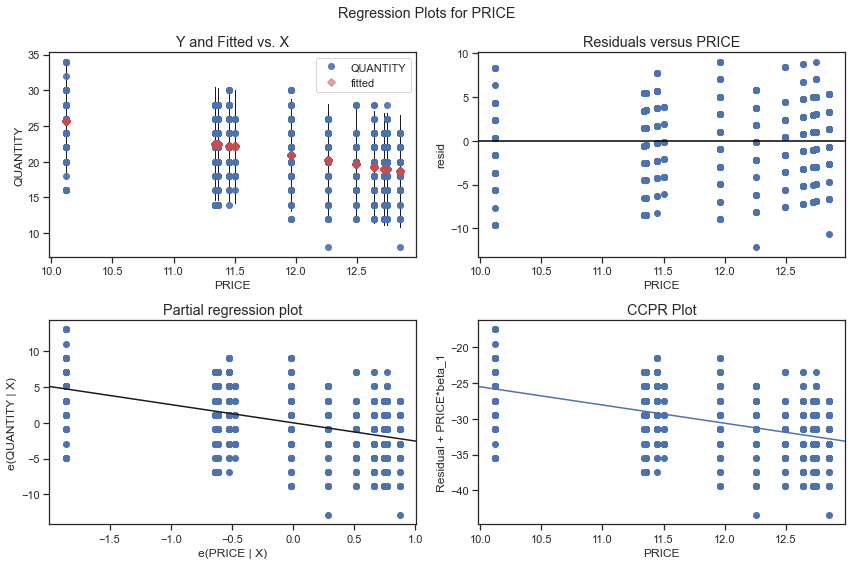

In [95]:
model_Lemonade = ols("QUANTITY ~ PRICE", data=Lemonade).fit()
print(model_Lemonade.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model_Lemonade, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_Lemonade, 'PRICE', fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
4,2052,2,LEMONADE,1/13/12,12.75,26,2012,No Holiday,0,0,26.6,0
20,2052,2,LEMONADE,1/13/14,11.96,24,2014,No Holiday,0,0,28.4,0
28,2052,2,LEMONADE,1/13/15,11.45,28,2015,No Holiday,0,0,28.4,0
52,2052,2,LEMONADE,1/14/14,11.96,26,2014,No Holiday,0,0,28.4,1
60,2052,2,LEMONADE,1/14/15,11.45,30,2015,No Holiday,0,0,30.2,0


(471, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,471.0,471.0,471.000000,471.00000,471.000000,471.0,471.0,471.000000,471.000000
mean,2052.0,2.0,11.967665,22.47983,2013.186837,0.0,0.0,53.691720,0.883227
std,0.0,0.0,0.842933,3.85469,1.059464,0.0,0.0,18.736854,0.321491
min,2052.0,2.0,10.120000,16.00000,2012.000000,0.0,0.0,14.000000,0.000000
25%,2052.0,2.0,11.360000,20.00000,2012.000000,0.0,0.0,35.600000,1.000000
50%,2052.0,2.0,12.260000,22.00000,2013.000000,0.0,0.0,53.600000,1.000000
75%,2052.0,2.0,12.720000,26.00000,2014.000000,0.0,0.0,70.700000,1.000000
max,2052.0,2.0,12.850000,34.00000,2015.000000,0.0,0.0,87.800000,1.000000


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

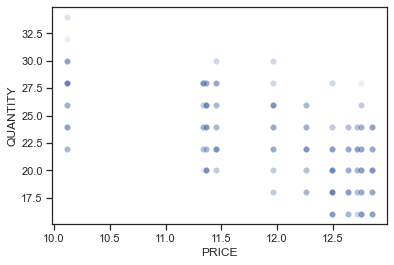

In [96]:
# considering normal day and other day (e.g. weekemd, holiday, etc) sales data for the analysis
LemonadeN = normalDays_data[normalDays_data['ITEM_NAME'] == 'LEMONADE']
LemonadeN.head()
LemonadeN.shape
LemonadeN.describe()
sns.scatterplot(x = LemonadeN.PRICE, y = LemonadeN.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     295.8
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           9.28e-52
Time:                        16:41:11   Log-Likelihood:                -1188.2
No. Observations:                 471   AIC:                             2380.
Df Residuals:                     469   BIC:                             2389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.5156      1.984     28.488      0.0

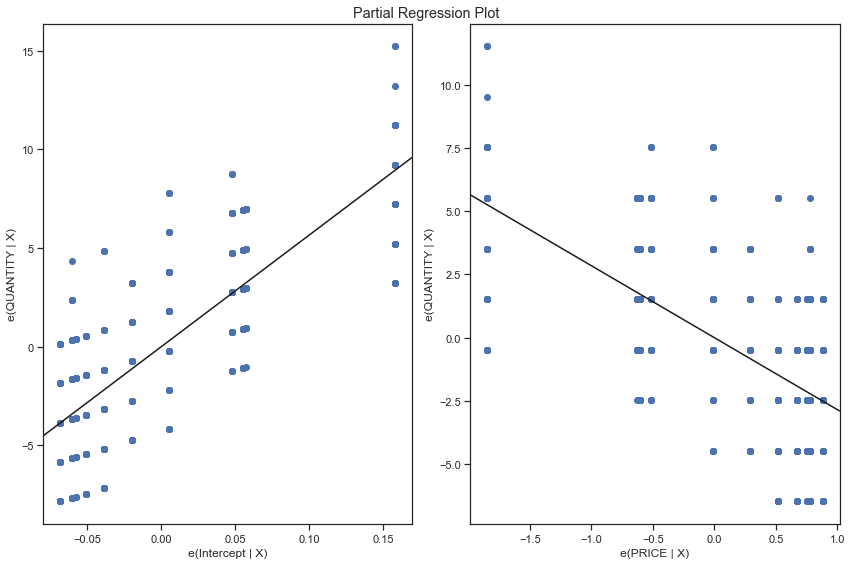

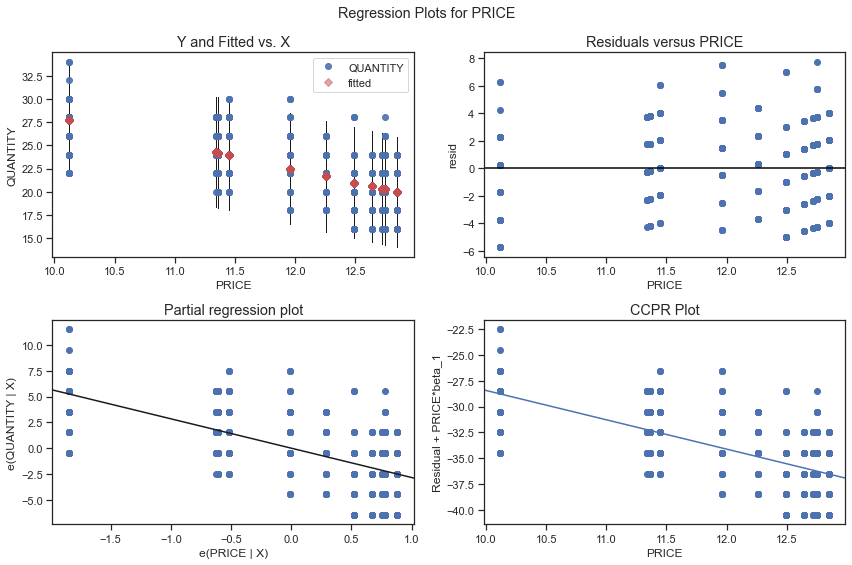

In [97]:
model_LemonadeN = ols("QUANTITY ~ PRICE", data=LemonadeN).fit()
print(model_LemonadeN.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model_LemonadeN, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_LemonadeN, 'PRICE', fig=fig)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
52,2052,2,LEMONADE,1/14/14,11.96,26,2014,No Holiday,0,0,28.4,1
92,2052,2,LEMONADE,1/15/15,11.45,28,2015,No Holiday,0,0,32.0,1
124,2052,2,LEMONADE,1/16/15,11.45,22,2015,No Holiday,0,0,32.0,1
452,2052,2,LEMONADE,1/27/12,12.75,18,2012,No Holiday,0,0,32.0,1
580,2052,2,LEMONADE,1/31/12,12.75,16,2012,No Holiday,0,0,32.0,1


(416, 12)

,SELL_ID,SELL_CATEGORY,PRICE,QUANTITY,YEAR,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
count,416.0,416.0,416.000000,416.000000,416.000000,416.0,416.0,416.000000,416.0
mean,2052.0,2.0,11.970264,22.028846,2013.201923,0.0,0.0,57.282212,1.0
std,0.0,0.0,0.849988,3.689011,1.076628,0.0,0.0,16.890613,0.0
min,2052.0,2.0,10.120000,16.000000,2012.000000,0.0,0.0,26.600000,1.0
25%,2052.0,2.0,11.360000,20.000000,2012.000000,0.0,0.0,41.000000,1.0
50%,2052.0,2.0,12.260000,22.000000,2013.000000,0.0,0.0,59.000000,1.0
75%,2052.0,2.0,12.720000,24.000000,2014.000000,0.0,0.0,71.600000,1.0
max,2052.0,2.0,12.850000,30.000000,2015.000000,0.0,0.0,87.800000,1.0


<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

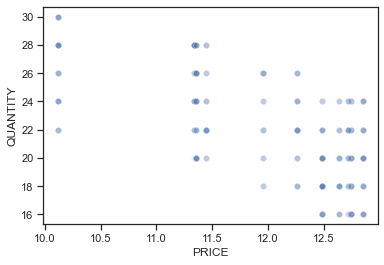

In [98]:
# considering normal day and other day (i.e. weekend and school break days) as well as filitering by outdoor sales data for the analysis
LemonadeN2 = normalDays_data2[normalDays_data2['ITEM_NAME'] == 'LEMONADE']
LemonadeN2.head()
LemonadeN2.shape
LemonadeN2.describe()
sns.scatterplot(x = LemonadeN2.PRICE, y = LemonadeN2.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     316.5
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           5.32e-53
Time:                        16:41:24   Log-Likelihood:                -1014.7
No. Observations:                 416   AIC:                             2033.
Df Residuals:                     414   BIC:                             2041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.2243      1.927     29.177      0.0

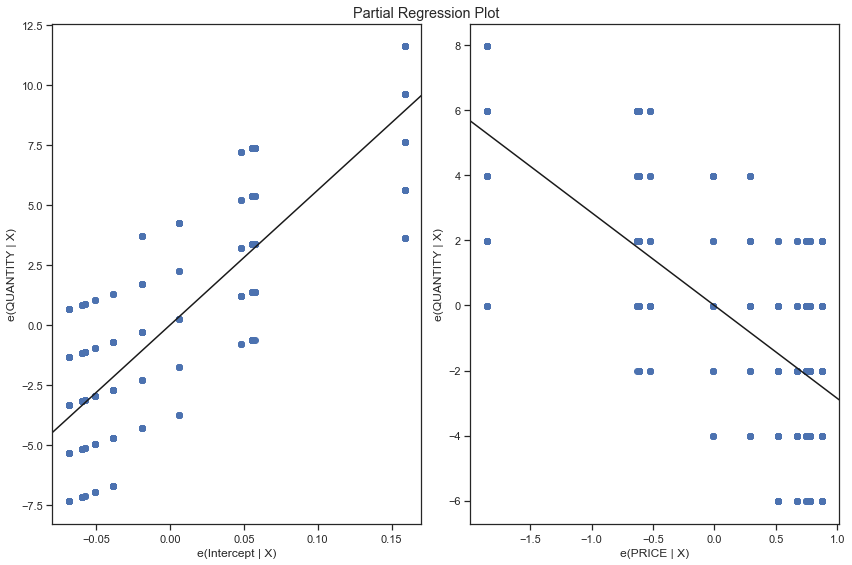

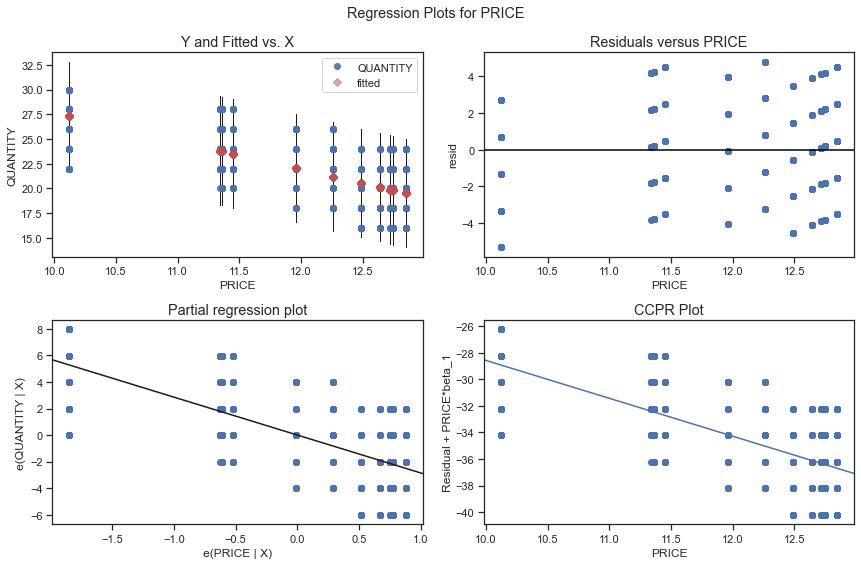

In [99]:
model_LemonadeN2 = ols("QUANTITY ~ PRICE", data=LemonadeN2).fit()
print(model_LemonadeN2.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model_LemonadeN2, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_LemonadeN2, 'PRICE', fig=fig)

#### Disaggregating the data by type of days and consideration of the sales by outdoor or not further improves the model fit.

In [100]:
elasticities = {}

In [101]:
def create_model_and_find_elasticity(data):
    model = ols("QUANTITY ~ PRICE", data).fit()
    price_elasticity = model.params[1]
    print("Price elasticity of the product: " + str(price_elasticity))
    print(model.summary())
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    return price_elasticity, model

The above function will be used to estimate price elacitcity for the normal days and sales filitered by IS_OUTDOOR, which is represented by normalDays_data2 data. 

In [102]:
# after refinment of the data, it is good to check which SELL_ID's remain for the ITEM_NAMEs
pd.concat([normalDays_data2.SELL_ID, pd.get_dummies(normalDays_data2.ITEM_NAME)], axis=1).groupby(normalDays_data2.SELL_ID).sum()

,SELL_ID,BURGER,COFFEE,COKE,LEMONADE
SELL_ID,,,,,
1070,445120,416.0,0.0,0.0,0.0
2051,1706432,416.0,0.0,416.0,0.0
2052,1707264,416.0,0.0,0.0,416.0
2053,2562144,416.0,416.0,416.0,0.0


All the SELL_IDs remain for Burger, SELL_ID 2053 for Coffee, 2051 and 2053 for Coke, and 2053 for Lemonade. Hence, the function will be run for this items and sell_ids. 

Price elasticity of the product: -8.658581488470569
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1804.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          5.51e-153
Time:                        16:41:45   Log-Likelihood:                -1038.8
No. Observations:                 416   AIC:                             2082.
Df Residuals:                     414   BIC:                             2090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


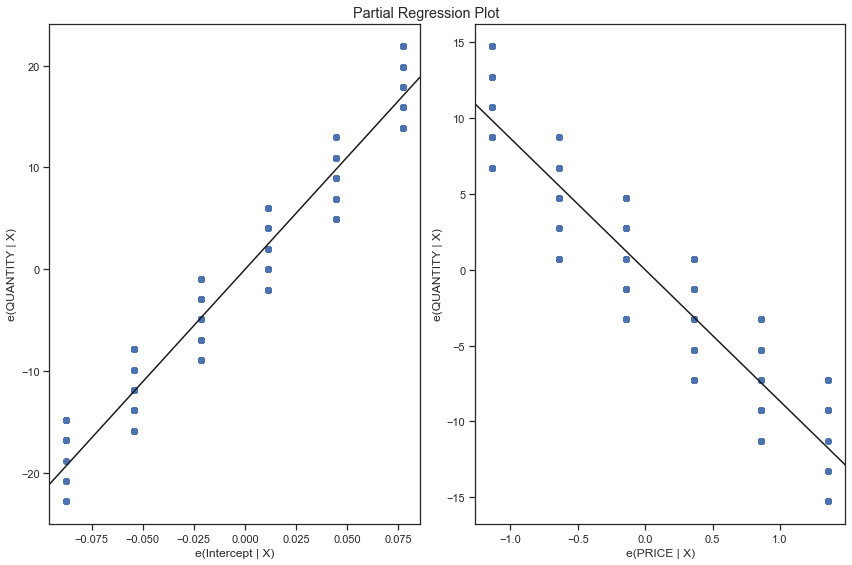

In [103]:
price_elasticity, model_burger_1070 = create_model_and_find_elasticity(Burger_1070N2)
elasticities['Burger_1070'] = price_elasticity

Price elasticity of the product: -3.618990615456312
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     363.3
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           1.34e-58
Time:                        16:41:50   Log-Likelihood:                -1021.5
No. Observations:                 416   AIC:                             2047.
Df Residuals:                     414   BIC:                             2055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


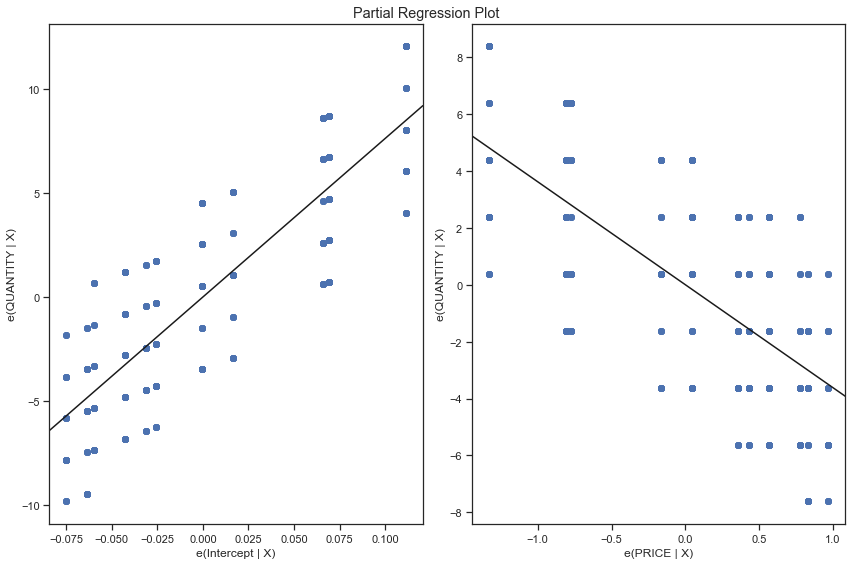

In [104]:
Burger_2051 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == "BURGER") & (normalDays_data2['SELL_ID'] == 2051)]
elasticities['Burger_2051'], model_burger_2051 = create_model_and_find_elasticity(Burger_2051)

Price elasticity of the product: -6.164156666230159
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          3.72e-152
Time:                        16:41:55   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


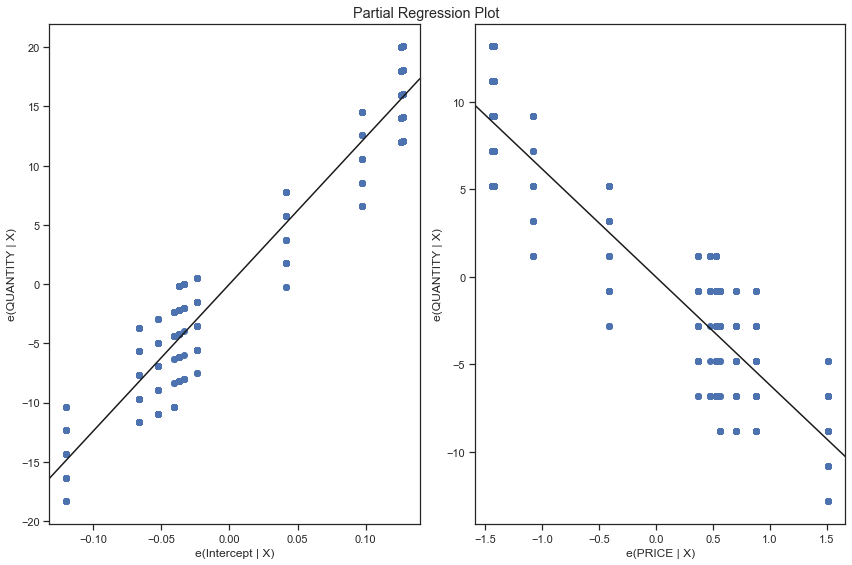

In [105]:
Burger_2053 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == "BURGER") & (normalDays_data2['SELL_ID'] == 2053)]
elasticities['Burger_2053'], model_burger_2053 = create_model_and_find_elasticity(Burger_2053)

Price elasticity of the product: -3.618990615456312
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     363.3
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           1.34e-58
Time:                        16:42:02   Log-Likelihood:                -1021.5
No. Observations:                 416   AIC:                             2047.
Df Residuals:                     414   BIC:                             2055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


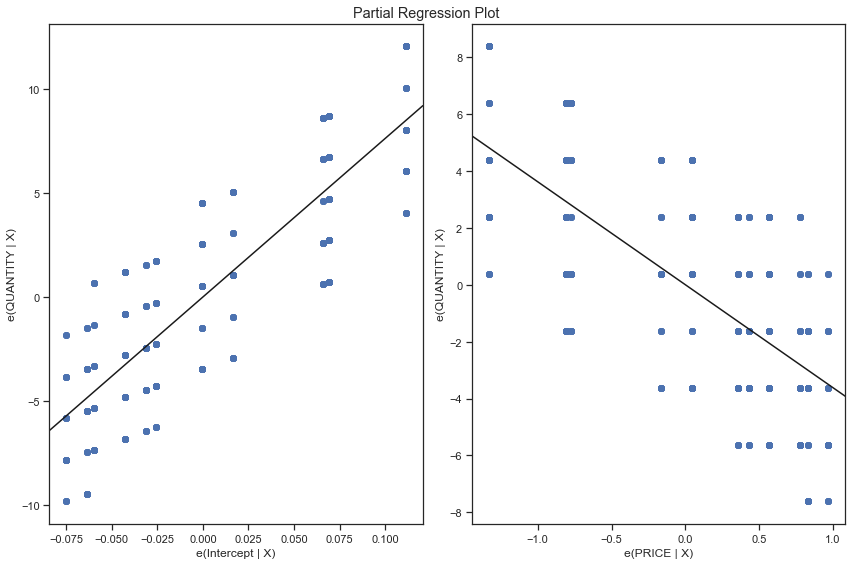

In [106]:
Coke_2051 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == "COKE") & (normalDays_data2['SELL_ID'] == 2051)]
elasticities['Coke_2051'], model_coke_2051 = create_model_and_find_elasticity(Coke_2051)

Price elasticity of the product: -6.164156666230159
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          3.72e-152
Time:                        16:42:07   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


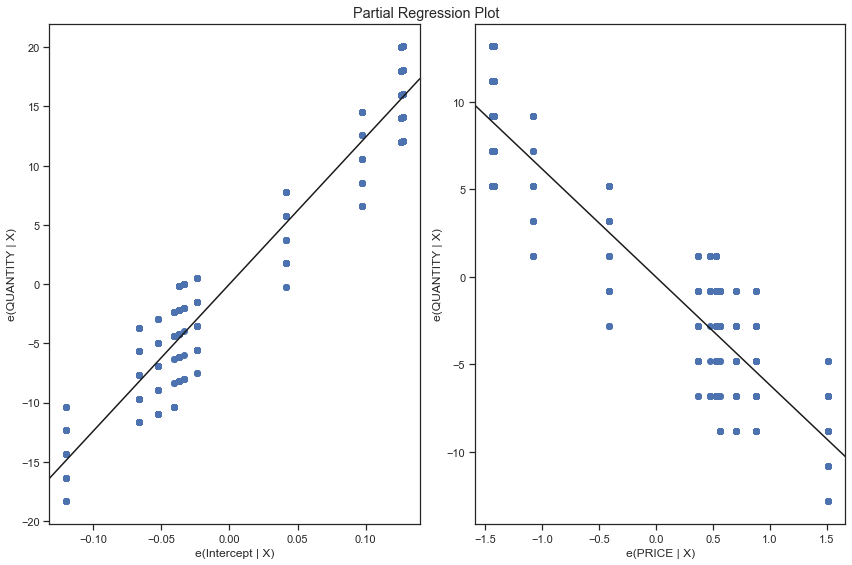

In [107]:
Coke_2053 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == "COKE") & (normalDays_data2['SELL_ID'] == 2053)]
elasticities['Coke_2053'], model_coke_2053 = create_model_and_find_elasticity(Coke_2053)

Price elasticity of the product: -2.856702984559962
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     316.5
Date:                Sat, 01 Jan 2022   Prob (F-statistic):           5.32e-53
Time:                        16:42:11   Log-Likelihood:                -1014.7
No. Observations:                 416   AIC:                             2033.
Df Residuals:                     414   BIC:                             2041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


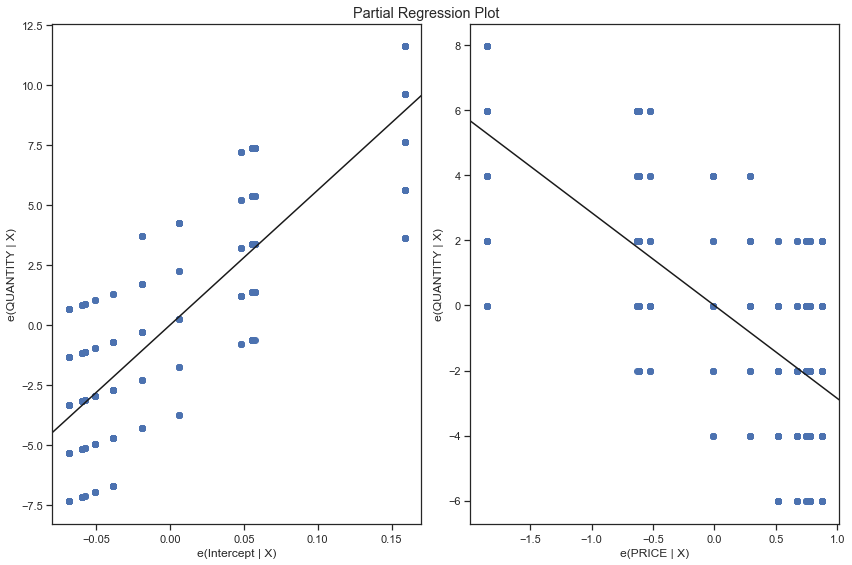

In [108]:
Lemonade_2052 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == "LEMONADE") & (normalDays_data2['SELL_ID'] == 2052)]
elasticities['Lemonade_2052'], model_lemonade_2052 = create_model_and_find_elasticity(Lemonade_2052)

Price elasticity of the product: -6.164156666230159
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):          3.72e-152
Time:                        16:42:15   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


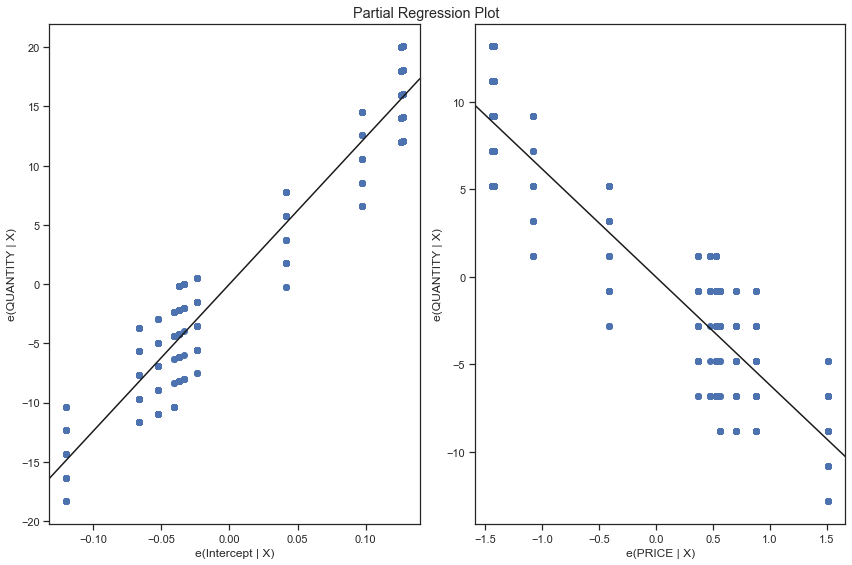

In [109]:
Coffee_2053 = normalDays_data2[(normalDays_data2['ITEM_NAME'] == "COFFEE") & (normalDays_data2['SELL_ID'] == 2053)]
elasticities['coffee_2053'], model_coffee_2053 = create_model_and_find_elasticity(Coffee_2053)

In [110]:
elasticities

{'Burger_1070': -8.658581488470569,
 'Burger_2051': -3.618990615456312,
 'Burger_2053': -6.164156666230159,
 'Coke_2051': -3.618990615456312,
 'Coke_2053': -6.164156666230159,
 'Lemonade_2052': -2.856702984559962,
 'coffee_2053': -6.164156666230159}

### Find optimal price for maximum profit

I will use lemonade sell with SELL_ID of 2052 (Lemonade_2052) to find the optimal price. Since the buying price of the lemonade by the cafe is not provided, I assumed it to be a little less than the minimum lemonade price in the dataset.

In [111]:
# minimum lemonade price
Lemonade_2052.PRICE.min()

10.12

In [112]:
# maximum lemonade price
Lemonade_2052.PRICE.max()

12.85

Hence, I assumed 9.25 as the buying price for lemonade. Hereafter, the aim is to find the optimal lemonade price that provides the maximum profit. PRICE is the selling price

In [113]:
buying_price_lemonade = 9.25

The profit can be calculated as follows:
$$Lemonade data.PROFIT = (Lemonade data.PRICE - buying price of lemonade) * Lemonade data.QUANTITY$$

The Lemonade data price is generated between the minimum and maximum selling price allowing some profit margins. While the quantity is calculated using the developed model for the generated price points.

In [114]:
# assuming the start and end price points based on the sell price data allowing some profit
start_price = 9.5
end_price = 19

In [115]:
demo_data = pd.DataFrame(columns = ["PRICE", "QUANTITY"])

#### generating price data points with 0.01 range

In [116]:
demo_data['PRICE'] = np.arange(start_price, end_price,0.01)

#### predicting quantity for the price using the model_lemonade_2052

In [117]:
# calculating the quantity sold based on the developed model
demo_data['QUANTITY'] = model_lemonade_2052.predict(demo_data['PRICE'])

In [118]:
demo_data

,PRICE,QUANTITY
0,9.50,29.085658
1,9.51,29.057091
2,9.52,29.028524
3,9.53,28.999957
4,9.54,28.971390
...,...,...
945,18.95,2.089815
946,18.96,2.061248
947,18.97,2.032681
948,18.98,2.004114


In [119]:
#calculating the profit for every price range
demo_data['PROFIT'] = (demo_data["PRICE"] - buying_price_lemonade) * demo_data["QUANTITY"]

In [120]:
demo_data

,PRICE,QUANTITY,PROFIT
0,9.50,29.085658,7.271414
1,9.51,29.057091,7.554844
2,9.52,29.028524,7.837701
3,9.53,28.999957,8.119988
4,9.54,28.971390,8.401703
...,...,...,...
945,18.95,2.089815,20.271203
946,18.96,2.061248,20.014715
947,18.97,2.032681,19.757656
948,18.98,2.004114,19.500025


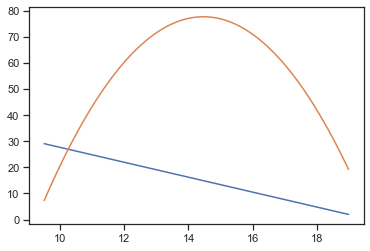

In [121]:
plt.plot(demo_data['PRICE'],demo_data['QUANTITY'])
plt.plot(demo_data['PRICE'],demo_data['PROFIT'])
plt.show()

#### finding the exact price where the maximum profit is achieved

In [122]:
index_max = np.where(demo_data['PROFIT'] == demo_data['PROFIT'].max())[0][0]

In [123]:
demo_data.loc[[index_max]]

,PRICE,QUANTITY,PROFIT
497,14.47,14.887844,77.714546


#### writting a generic function that plots the price ~ quantity and price ~ quantity plots as well as finds optimal profit selling price

In [128]:
def find_optimal_price(data, model, buying_price):
    start_price = data.PRICE.min() - 1                  # starting price point for sales assuming the min price in the data -1.
    end_price = data.PRICE.min() + 10                   # ending price point for sales assuming the mix price in the data + 10
    demo_data = pd.DataFrame(columns = ["PRICE", "QUANTITY"])
    demo_data['PRICE'] = np.arange(start_price, end_price,0.01)
    demo_data['QUANTITY'] = model.predict(demo_data['PRICE'])
    demo_data['PROFIT'] = (demo_data["PRICE"] - buying_price) * demo_data["QUANTITY"]
    plt.plot(demo_data['PRICE'],demo_data['QUANTITY'])
    plt.plot(demo_data['PRICE'],demo_data['PROFIT'])
    plt.show()
    index_at_max_profit = np.where(demo_data['PROFIT'] == demo_data['PROFIT'].max())[0][0]
    values_at_max_profit = demo_data.iloc[[index_at_max_profit]]
    return values_at_max_profit
    

### Calculating the optimal price for all and list in table

In [129]:
optimal_price = {}

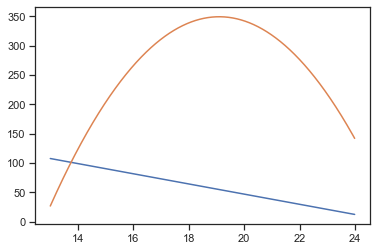

In [130]:
buying_price = Burger_1070N2.PRICE.min() - 1.25              # assuming some profit margine from the start price
optimal_price['Burger_1070N2'] = find_optimal_price(Burger_1070N2, model_burger_1070, buying_price)

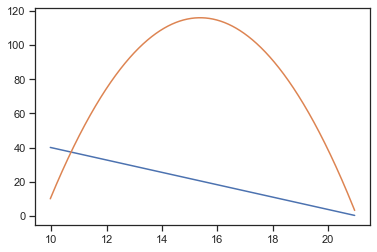

In [131]:
buying_price = Burger_2051N2.PRICE.min() - 1.25  
optimal_price['Burger_2051N2'] = find_optimal_price(Burger_2051N2, model_burger_2051, buying_price)

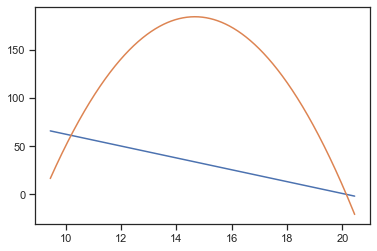

In [132]:
buying_price = Burger_2053.PRICE.min() - 1.25  
optimal_price['Burger_2053'] = find_optimal_price(Burger_2053, model_burger_2053, buying_price)

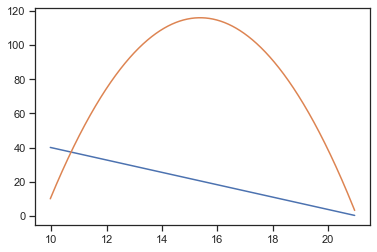

In [134]:
buying_price = Coke_2051.PRICE.min() - 1.25  
optimal_price['Coke_2051'] = find_optimal_price(Coke_2051, model_coke_2051, buying_price)

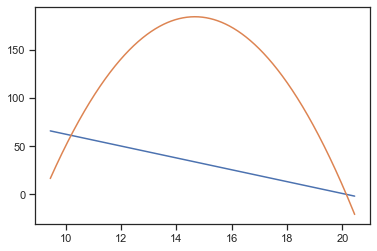

In [135]:
buying_price = Coke_2053.PRICE.min() - 1.25  
optimal_price['Coke_2053'] = find_optimal_price(Coke_2053, model_coke_2053, buying_price)

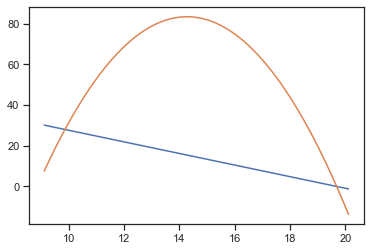

In [137]:
buying_price = Lemonade_2052.PRICE.min() - 1.25 
optimal_price['Lemonade_2052'] = find_optimal_price(Lemonade_2052, model_lemonade_2052, buying_price)

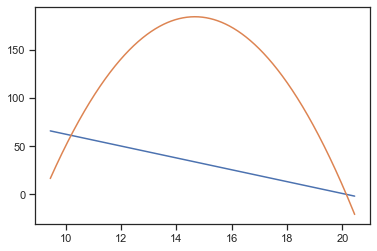

In [138]:
buying_price = Coffee_2053.PRICE.min() - 1.25 
optimal_price['Coffee_2053'] = find_optimal_price(Coffee_2053, model_coffee_2053, buying_price)

In [139]:
optimal_price

{'Burger_1070N2':      PRICE  QUANTITY      PROFIT
 610   19.1  54.98106  349.129734,
 'Burger_2051N2':      PRICE   QUANTITY      PROFIT
 541  15.38  20.479356  115.913154,
 'Burger_2053':      PRICE   QUANTITY      PROFIT
 522  14.67  33.713535  184.413036,
 'Coke_2051':      PRICE   QUANTITY      PROFIT
 541  15.38  20.479356  115.913154,
 'Coke_2053':      PRICE   QUANTITY      PROFIT
 522  14.67  33.713535  184.413036,
 'Lemonade_2052':      PRICE   QUANTITY     PROFIT
 516  14.28  15.430618  83.479641,
 'Coffee_2053':      PRICE   QUANTITY      PROFIT
 522  14.67  33.713535  184.413036}

### Key messages

This cafe's data was a available in three data files. The data were combined removing the unnessary features. The data was explored to understand its characteristics and model it properly. For example, it was found reasonable to separate normal days sales from other days such as weekends and schoolbreak days sales as they have different distributions due to differnt customer buying behaviours. Moreover, the modeling showed that disaggregating the data by outdoor sales imporoved the model fit further. Finally, prices that yield maximum profit for the cafe were estimated (assuming buying prices) for the items. 